In [1]:
"""環境"""
# .lab

"""更新履歴"""
# 最終更新日：2025/08/12
# 2025/08/12 inputsは使わないことにしました。
# 2025/08/04 cachedirの洗浄をオプションにしました。
# 2025/07/22 pickleを保存するために、pickleとdatetimeをインポートするようにしました。
# 2025/07/17 inputsを保存するjsonを作ることにしました
# 2025/07/17 ctypesを使ってtkinterの解像度を上げることにしました
# 2025/05/21 shutilを使って、cachedirを洗浄することにしました
# 2025/05/15 simple_progress_barおよびdata(dict)を使い始めました。
# 2025/02/25 os.getcwd()を採用し、__file__を定義する必要をなくしました。

"""モジュール読み込み"""
# ファイル操作等
import sys
import os
from datetime import datetime
from pprint import pprint
import logging
import pickle
# import struct
from tqdm import tqdm
import h5py
# import threading
import json
import shutil

# tkinter
from tkinter import filedialog, messagebox, Tk
import ctypes
ctypes.windll.shcore.SetProcessDpiAwareness(1) # tkinterの解像度を上げる

# データ分析ツール
import pandas as pd
import numpy as np
import scipy as sp
# import math
# from sklearn.linear_model import LinearRegression

# グラフ等作成用
import matplotlib
import matplotlib.pyplot as plt         # 図の作成用
from PIL import Image as im
# import cv2
from IPython.display import display, HTML, clear_output, update_display, Image

# 自作モジュール
sys.path.append(r"C:\Users\okaza\pythonenv")
from modules.Mytools.Tools import print_fileinfo, h5_tree, dict_tree, simple_progress_bar, clean_cache_except_logfiles, get_total_size
import modules.Mytools.Settings
import modules.fitXRD as fx
from modules.peakfit import peakfit, pseudoVoigt

"""ログ管理ツール作成"""
# chche directoryの設定
cachedir = os.path.abspath(os.getcwd() + "/.cache")
if False:
    clean_cache_except_logfiles(cachedir)
os.makedirs(cachedir, exist_ok=True)

# loggerの作成
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
format = "%(levelname)-9s  %(asctime)s [%(filename)s:%(lineno)d] %(message)s"

# Streamハンドラクラスを作成
sh = logging.StreamHandler()
sh.setLevel(logging.DEBUG)
sh.setFormatter(logging.Formatter(format))
logger.addHandler(sh)

# Fileハンドラクラスをインスタンス化
logfile = cachedir + ""
fh = logging.FileHandler(filename=cachedir + "/notebook.log", encoding="utf-8")
fh.setLevel(logging.DEBUG)
fh.setFormatter(logging.Formatter(format))
logger.addHandler(fh)
logger.debug("[Activate workspace]: " + os.getcwd())
logger.debug("[Set cache]: "+ os.path.abspath(cachedir))
logger.debug("[Activate log]: " + os.path.abspath(cachedir + "/notebook.log"))

# globalなデータを作成
data = dict()
logger.debug("[Create global variable]: data")

DEBUG      2025-08-29 13:25:55,593 [2155881028.py:80] [Activate workspace]: c:\Users\okaza\Documents\Friction
DEBUG      2025-08-29 13:25:55,604 [2155881028.py:81] [Set cache]: c:\Users\okaza\Documents\Friction\.cache
DEBUG      2025-08-29 13:25:55,607 [2155881028.py:82] [Activate log]: c:\Users\okaza\Documents\Friction\.cache\notebook.log
DEBUG      2025-08-29 13:25:55,609 [2155881028.py:86] [Create global variable]: data


生データの保存

In [6]:
def save_pickle():

    """変更履歴
    * 2025/08/29: initialdirの設定
    * 2025/08/05: defaultextensitionを追加、initialdirの削除
    * 2025/08/01: 作成ののち変更
    """

    # デフォルトの設定
    dt = datetime.now()
    initfilename = dt.strftime('%Y%m%d%H%M%S%f') + ".pkl"

    # tkinterでファイルダイアログを開く
    window = Tk()
    window.wm_attributes("-topmost", 1)
    window.withdraw()
    filename = filedialog.asksaveasfilename(
        parent = window,
        filetypes = [
            ("pkl", "*.pkl"),
        ],
        initialdir=cachedir,
        initialfile=initfilename,
        defaultextension=".pkl",
    )

    # filenameがセットされたら保存する
    if not (filename == ""):
        with open(filename, mode = "wb") as f:
            pickle.dump(
                obj = data,
                file = f
            )
    logger.info("[Save data]: " + os.path.abspath(filename))

    return
save_pickle()
del save_pickle

INFO       2025-08-29 13:28:44,537 [1307908033.py:34] [Save data]: c:\Users\okaza\Documents\Friction


生データの読み込み

In [ ]:
def load_pickle():

    """変更履歴
    * 2025/08/29: initialdirを設定しました
    * 2025/08/26: dataのサイズを出力するようにしました。
    * 2025/08/04: dataの上書きができていませんでした
    * 2025/07/25: 作成
    """

    # tkinterでファイルダイアログを開く
    window = Tk()
    window.wm_attributes("-topmost", 1)
    window.withdraw()
    filename = filedialog.askopenfilename(
        parent = window,
        filetypes = [
            ("pkl", "*.pkl"),
        ],
        initialdir=cachedir,
    )
    global data
    if not (filename == ""):
        with open(filename, mode = "rb") as f:
            data = pickle.load(
                file = f
            )
    logger.info("[Load]: " + os.path.abspath(filename))
    logger.info("[Data size]: {:.2f} MB".format(get_total_size(data)/1024/1024))
    dict_tree(data)

    return
load_pickle()
del load_pickle

INFO       2025-08-29 13:28:49,894 [943107938.py:26] [Load]: c:\Users\okaza\Documents\Friction
INFO       2025-08-29 13:28:49,896 [943107938.py:27] [Data size]: 3.58


<class 'dict'>  (size = 3.58 MB)
└── load_data
    ├── mechanical
    │   ├── EFT_0008_0000
    │   │   ├── Time [s] <class 'numpy.ndarray'> [shape = (486,)]
    │   │   ├── Normal Force [kN] <class 'numpy.ndarray'> [shape = (486,)]
    │   │   ├── Normal Displacement [mm] <class 'numpy.ndarray'> [shape = (486,)]
    │   │   ├── Shear Displacement [mm] <class 'numpy.ndarray'> [shape = (486,)]
    │   │   └── Shear Force [kN] <class 'numpy.ndarray'> [shape = (486,)]
    │   ├── EFT_0008_0001
    │   │   ├── Time [s] <class 'numpy.ndarray'> [shape = (47484,)]
    │   │   ├── Normal Force [kN] <class 'numpy.ndarray'> [shape = (47484,)]
    │   │   ├── Normal Displacement [mm] <class 'numpy.ndarray'> [shape = (47484,)]
    │   │   ├── Shear Displacement [mm] <class 'numpy.ndarray'> [shape = (47484,)]
    │   │   └── Shear Force [kN] <class 'numpy.ndarray'> [shape = (47484,)]
    │   └── EFT_0008_0002
    │       ├── Time [s] <class 'numpy.ndarray'> [shape = (41908,)]
    │       ├── Normal

## 目的

摩擦実験のデータを可視化する。

## データ読み込み

データを読み込みます。

In [103]:
def load_data():

    mechanical_files = [
        r"C:\Users\okaza\Box\DataStrorage\EFT_0008\Others\EFT_0008_Okazaki_0000.CSV",
        r"C:\Users\okaza\Box\DataStrorage\EFT_0008\Others\EFT_0008_Okazaki_0001.CSV",
        r"C:\Users\okaza\Box\DataStrorage\EFT_0008\Others\EFT_0008_Okazaki_0002.CSV",
    ]
    dd = dict()
    for i in range(3):
        label = "EFT_0008_{:0>4}".format(i)
        df = pd.read_csv(
            mechanical_files[i],
            encoding="shift-jis",
            header = 13
        )
        df.columns = [
            "Time [s]",
            "Normal Force [kN]",
            "Normal Displacement [mm]",
            "Shear Displacement [mm]",
            "Shear Force [kN]" 
        ]
        d = df.to_dict(orient = "list")
        for k in d.keys():
            d[k] = np.array(d[k])
        dd[label] = d

    temperature_file = r"C:\Users\okaza\Box\DataStrorage\EFT_0008\Temperature\250825-152716.CSV"
    df = pd.read_csv(
        temperature_file,
        encoding = "shift-jis",
        header = 30,
        index_col=None,
        usecols=[4,5]
    )
    df.columns = [
        "top [degree]",
        "bottom [degree]"
    ]
    d = df.to_dict(orient = "list")
    for k in d.keys():
        d[k] = np.array(list(map(lambda x: float(x.replace(" ", "")), d[k])))

    key = sys._getframe().f_code.co_name
    data[key] = dict()
    data[key]["mechanical"] = dd
    data[key]["temperature"] = d
    logger.info("[Add data]: key = {}".format(key))
    dict_tree(data)

    return
load_data()
del load_data

INFO       2025-08-29 14:47:27,801 [1530285128.py:48] [Add data]: key = load_data


<class 'dict'>  (size = 3.58 MB)
├── load_data
│   ├── mechanical
│   │   ├── EFT_0008_0000
│   │   │   ├── Time [s] <class 'numpy.ndarray'> [shape = (486,)]
│   │   │   ├── Normal Force [kN] <class 'numpy.ndarray'> [shape = (486,)]
│   │   │   ├── Normal Displacement [mm] <class 'numpy.ndarray'> [shape = (486,)]
│   │   │   ├── Shear Displacement [mm] <class 'numpy.ndarray'> [shape = (486,)]
│   │   │   └── Shear Force [kN] <class 'numpy.ndarray'> [shape = (486,)]
│   │   ├── EFT_0008_0001
│   │   │   ├── Time [s] <class 'numpy.ndarray'> [shape = (47484,)]
│   │   │   ├── Normal Force [kN] <class 'numpy.ndarray'> [shape = (47484,)]
│   │   │   ├── Normal Displacement [mm] <class 'numpy.ndarray'> [shape = (47484,)]
│   │   │   ├── Shear Displacement [mm] <class 'numpy.ndarray'> [shape = (47484,)]
│   │   │   └── Shear Force [kN] <class 'numpy.ndarray'> [shape = (47484,)]
│   │   └── EFT_0008_0002
│   │       ├── Time [s] <class 'numpy.ndarray'> [shape = (41908,)]
│   │       ├── Normal

## 時刻合わせ

時間を合わせます。

DEBUG      2025-08-26 18:43:57,514 [2185843338.py:109] [Save fig]: c:\Users\okaza\Documents\Friction\.cache\get_grad_with_variousSigma.png
DEBUG      2025-08-26 18:43:57,517 [2185843338.py:112] [Save pdf]: c:\Users\okaza\Documents\Friction\.cache\get_grad_with_variousSigma.pdf


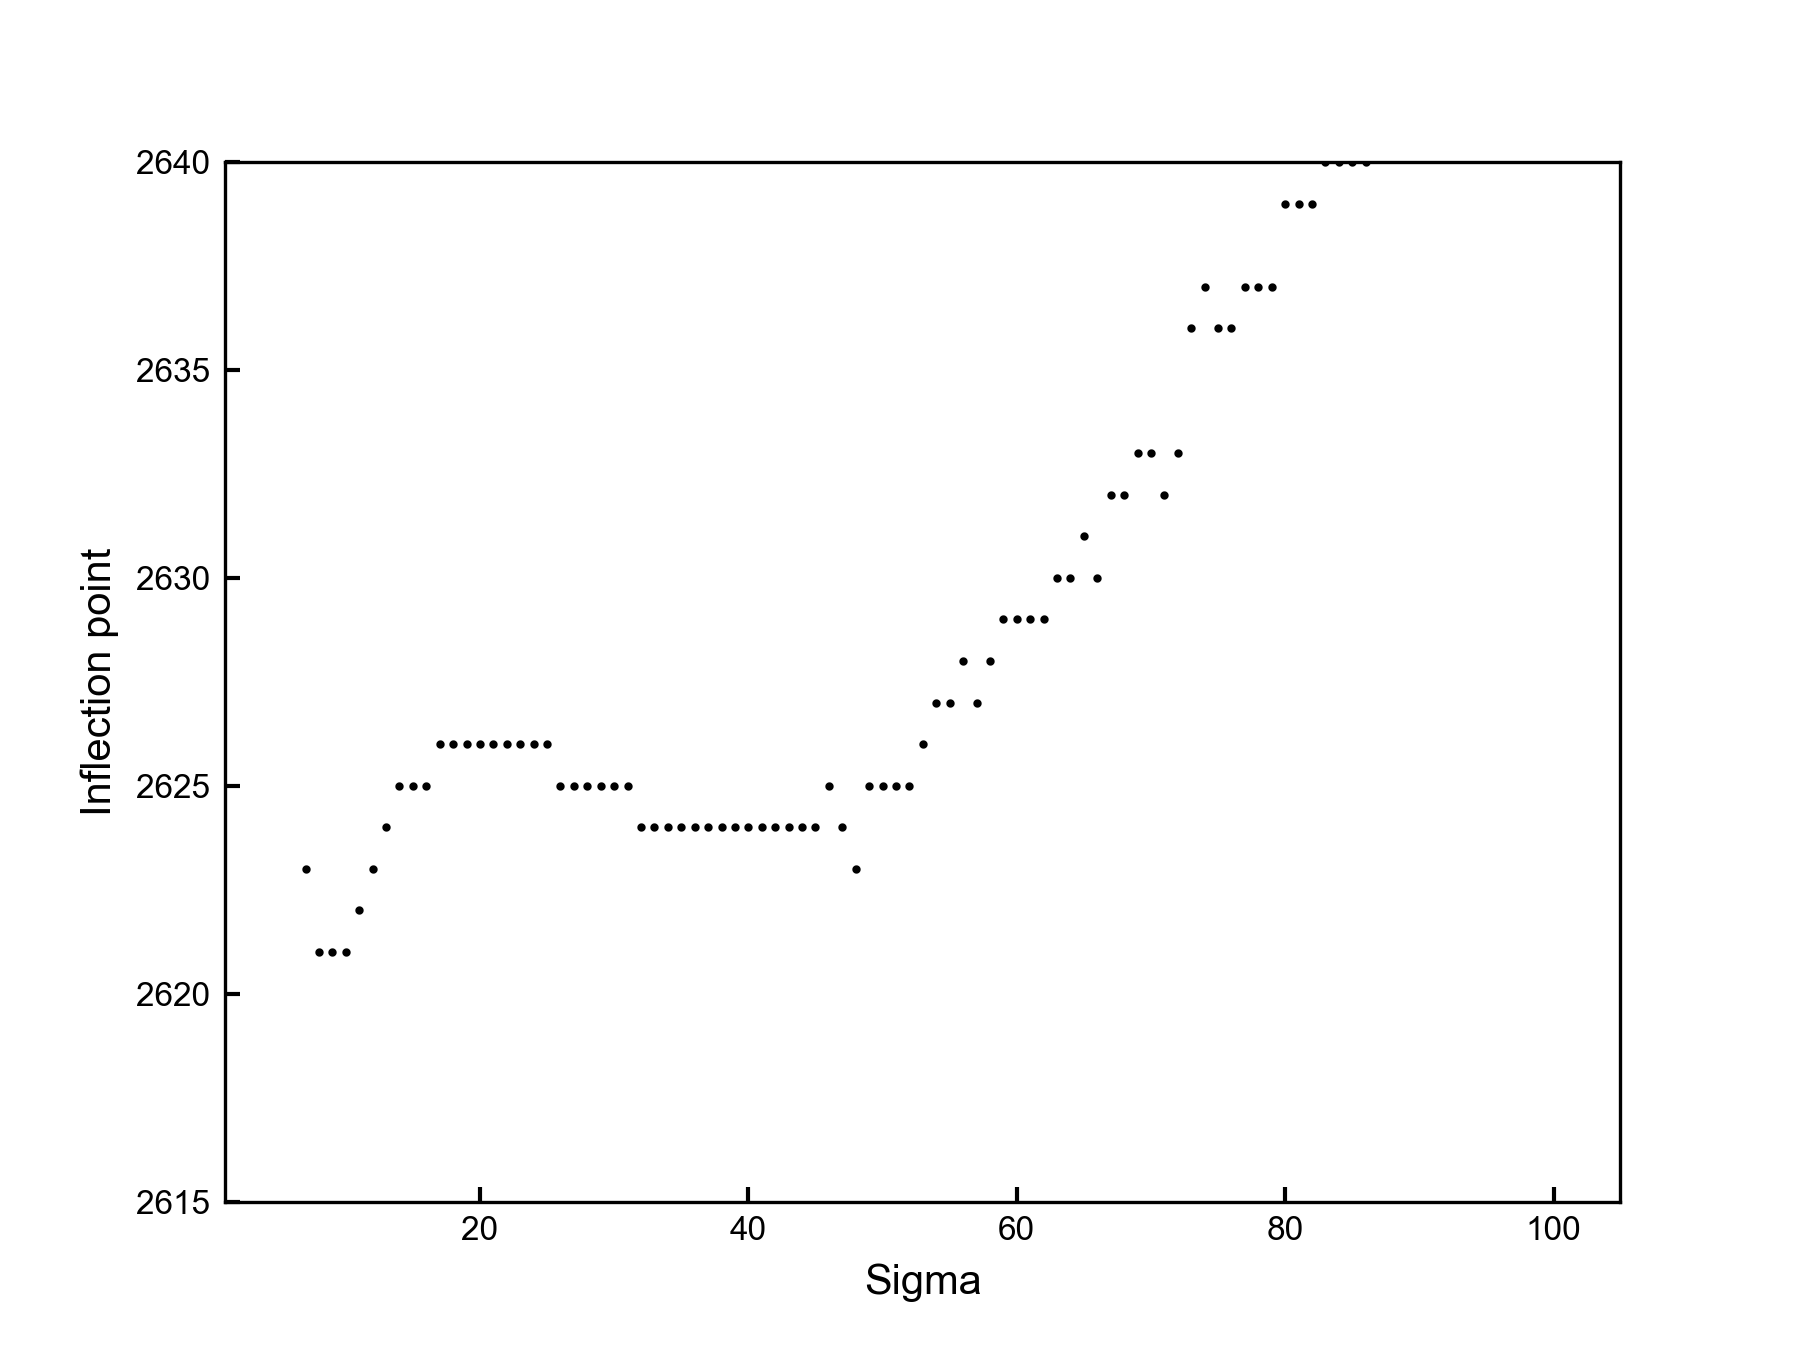

In [448]:
def get_grad_with_variousSigma():

    # 微分するxの値
    x = data["load_data"]["temperature"]["bottom [degree]"].copy()

    # 時間データ
    t = np.arange(x.shape[0])

    # 微分する範囲
    tlim = (2500, 3000)

    # sigmaの範囲
    sigmalim = (1, 100)

    # 表示するグラフ
    switch = 2

    # 時系列データを出力する際のsigmaの値
    sigma_figure = 25

    # 変曲点の範囲 (optional)
    iplim = (2615, 2640)

    if True: # Main
        """更新履歴
        * 2025/08/26: 作成
        """
        
        # mask
        mask = np.ones(t.shape).astype(np.bool_)
        mask[t < tlim[0]] = False
        mask[t > tlim[1]] = False

        # 微分
        sigma = np.linspace(*sigmalim,100)
        filtered = []
        gradient = []
        argmax = []
        for s in sigma:
            # フィルタリング
            x_filtered = sp.ndimage.gaussian_filter1d(
                x[mask],
                sigma = s
            )
            filtered.append(x_filtered)

            # 微分する
            grad = np.gradient(np.gradient(x_filtered, t[mask]), t[mask])
            gradient.append(grad)

            # 最大値を求める
            argmax.append(t[mask][np.argmax(grad)])

        # # figure作成
        fig, ax = plt.subplots()
        size_inches = (6,4.5)
        fig.set_size_inches(size_inches)
        fig.set_dpi(300)

        # plot
        if switch == 0:
            index = np.argmin(np.abs(sigma - sigma_figure))
            ax.plot(
                t[mask],
                filtered[index],
                lw = 1,
                c = "0",
            )
            ax.set_title("sigma = {}".format(sigma[index]), loc = "left")
            ax.set_xlabel("Time [s]", fontsize = 10)
            ax.set_ylabel("x", fontsize = 10)
        elif switch == 1:
            ax.plot(
                t[mask],
                gradient[np.argmin(np.abs(sigma - s))],
                lw = 1,
                c = "0",
            )
            ax.set_title("sigma = {}".format(sigma[np.argmin(np.abs(sigma - sigma_figure))]))
            ax.set_xlabel("Time [s]", fontsize = 10)
            ax.set_ylabel("D2x")
        elif switch == 2:
            ax.plot(
                sigma,
                argmax,
                lw = 0,
                marker = "o",
                ms = 1,
                c = "0"
            )
            ax.set_xlabel("Sigma", fontsize = 10)
            ax.set_ylabel("Inflection point", fontsize = 10)
            ax.set_xlim((1,ax.get_xlim()[1]))
            if "iplim" in locals():
                ax.set_ylim(iplim) # type: ignore

        # 出力等
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        plt.close()
        key = sys._getframe().f_code.co_name
        imgfilename = os.path.join(cachedir, key + ".png")
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
        pdffilename = os.path.join(cachedir, key + ".pdf")
        plt.savefig(pdffilename)
        logger.debug("[Save pdf]: " + os.path.abspath(pdffilename))
        plt.close()
        display(Image(filename = imgfilename, width = size_inches[0]*100))

    return
get_grad_with_variousSigma()
del get_grad_with_variousSigma

DEBUG      2025-08-26 18:40:14,696 [4040159305.py:110] [Save fig]: c:\Users\okaza\Documents\Friction\.cache\get_grad_with_variousSigma.png
DEBUG      2025-08-26 18:40:14,699 [4040159305.py:113] [Save pdf]: c:\Users\okaza\Documents\Friction\.cache\get_grad_with_variousSigma.pdf


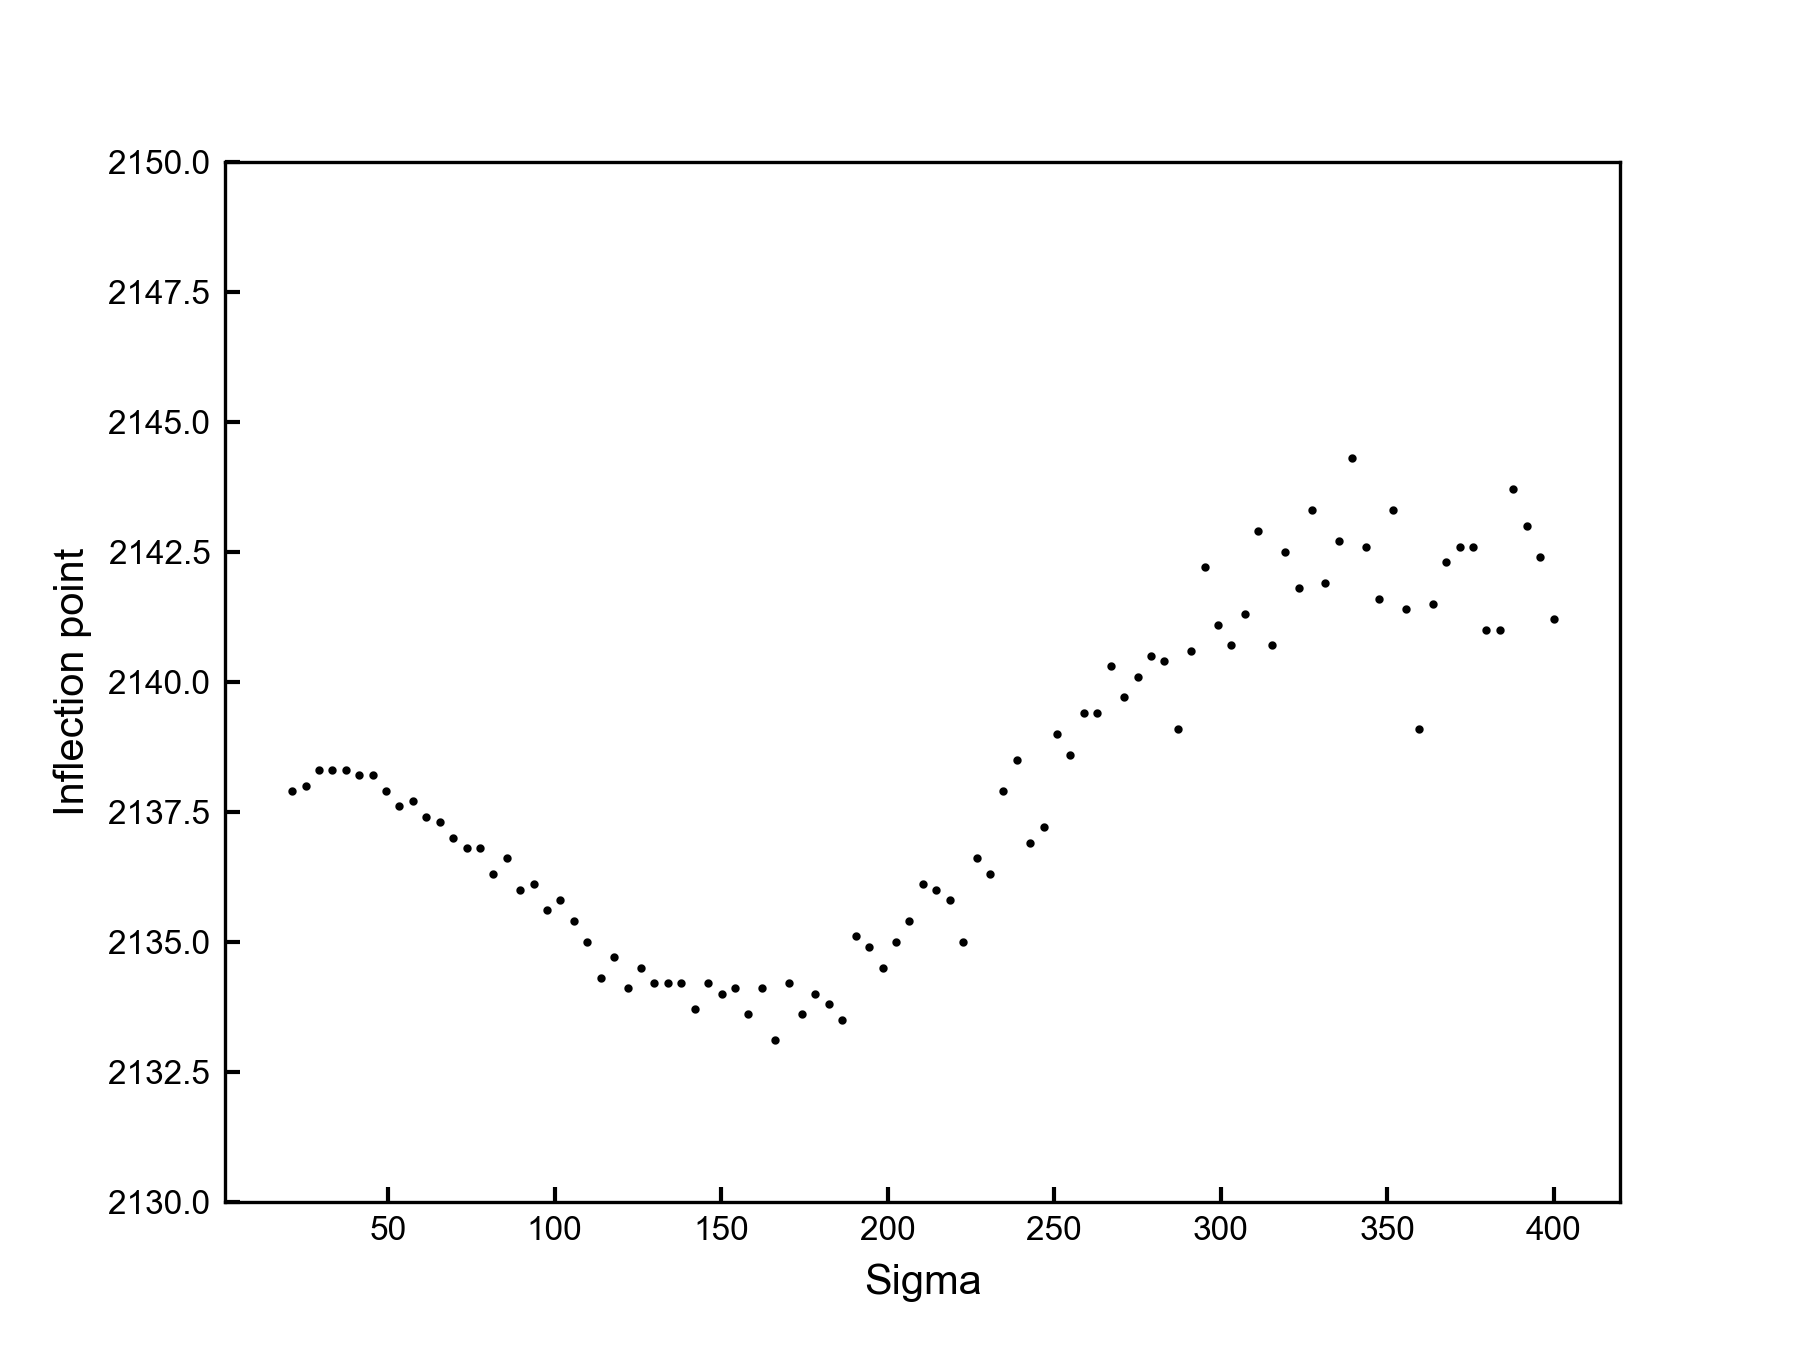

In [447]:
def get_grad_with_variousSigma():

    # 微分するxの値
    x = data["load_data"]["mechanical"]["EFT_0008_0001"]["Normal Force [kN]"].copy()
    x *= -1

    # 時間データ
    t = np.arange(x.shape[0]) / 10

    # 微分する範囲
    tlim = (2000, 2500)

    # sigmaの範囲
    sigmalim = (1, 400)

    # 表示するグラフ
    switch = 2

    # 時系列データを出力する際のsigmaの値
    sigma_figure = 25

    # 変曲点の範囲 (optional)
    iplim = (2130, 2150)

    if True: # Main
        """更新履歴
        * 2025/08/26: 作成
        """
        
        # mask
        mask = np.ones(t.shape).astype(np.bool_)
        mask[t < tlim[0]] = False
        mask[t > tlim[1]] = False

        # 微分
        sigma = np.linspace(*sigmalim,100)
        filtered = []
        gradient = []
        argmax = []
        for s in sigma:
            # フィルタリング
            x_filtered = sp.ndimage.gaussian_filter1d(
                x[mask],
                sigma = s
            )
            filtered.append(x_filtered)

            # 微分する
            grad = np.gradient(np.gradient(x_filtered, t[mask]), t[mask])
            gradient.append(grad)

            # 最大値を求める
            argmax.append(t[mask][np.argmax(grad)])

        # # figure作成
        fig, ax = plt.subplots()
        size_inches = (6,4.5)
        fig.set_size_inches(size_inches)
        fig.set_dpi(300)

        # plot
        if switch == 0:
            index = np.argmin(np.abs(sigma - sigma_figure))
            ax.plot(
                t[mask],
                filtered[index],
                lw = 1,
                c = "0",
            )
            ax.set_title("sigma = {}".format(sigma[index]), loc = "left")
            ax.set_xlabel("Time [s]", fontsize = 10)
            ax.set_ylabel("x", fontsize = 10)
        elif switch == 1:
            ax.plot(
                t[mask],
                gradient[np.argmin(np.abs(sigma - s))],
                lw = 1,
                c = "0",
            )
            ax.set_title("sigma = {}".format(sigma[np.argmin(np.abs(sigma - sigma_figure))]))
            ax.set_xlabel("Time [s]", fontsize = 10)
            ax.set_ylabel("D2x")
        elif switch == 2:
            ax.plot(
                sigma,
                argmax,
                lw = 0,
                marker = "o",
                ms = 1,
                c = "0"
            )
            ax.set_xlabel("Sigma", fontsize = 10)
            ax.set_ylabel("Inflection point", fontsize = 10)
            ax.set_xlim((1,ax.get_xlim()[1]))
            if "iplim" in locals():
                ax.set_ylim(iplim) # type: ignore

        # 出力等
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        plt.close()
        key = sys._getframe().f_code.co_name
        imgfilename = os.path.join(cachedir, key + ".png")
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
        pdffilename = os.path.join(cachedir, key + ".pdf")
        plt.savefig(pdffilename)
        logger.debug("[Save pdf]: " + os.path.abspath(pdffilename))
        plt.close()
        display(Image(filename = imgfilename, width = size_inches[0]*100))

    return
get_grad_with_variousSigma()
del get_grad_with_variousSigma

DEBUG      2025-08-26 19:00:09,380 [802160464.py:109] [Save fig]: c:\Users\okaza\Documents\Friction\.cache\get_grad_with_variousSigma.png
DEBUG      2025-08-26 19:00:09,383 [802160464.py:112] [Save pdf]: c:\Users\okaza\Documents\Friction\.cache\get_grad_with_variousSigma.pdf


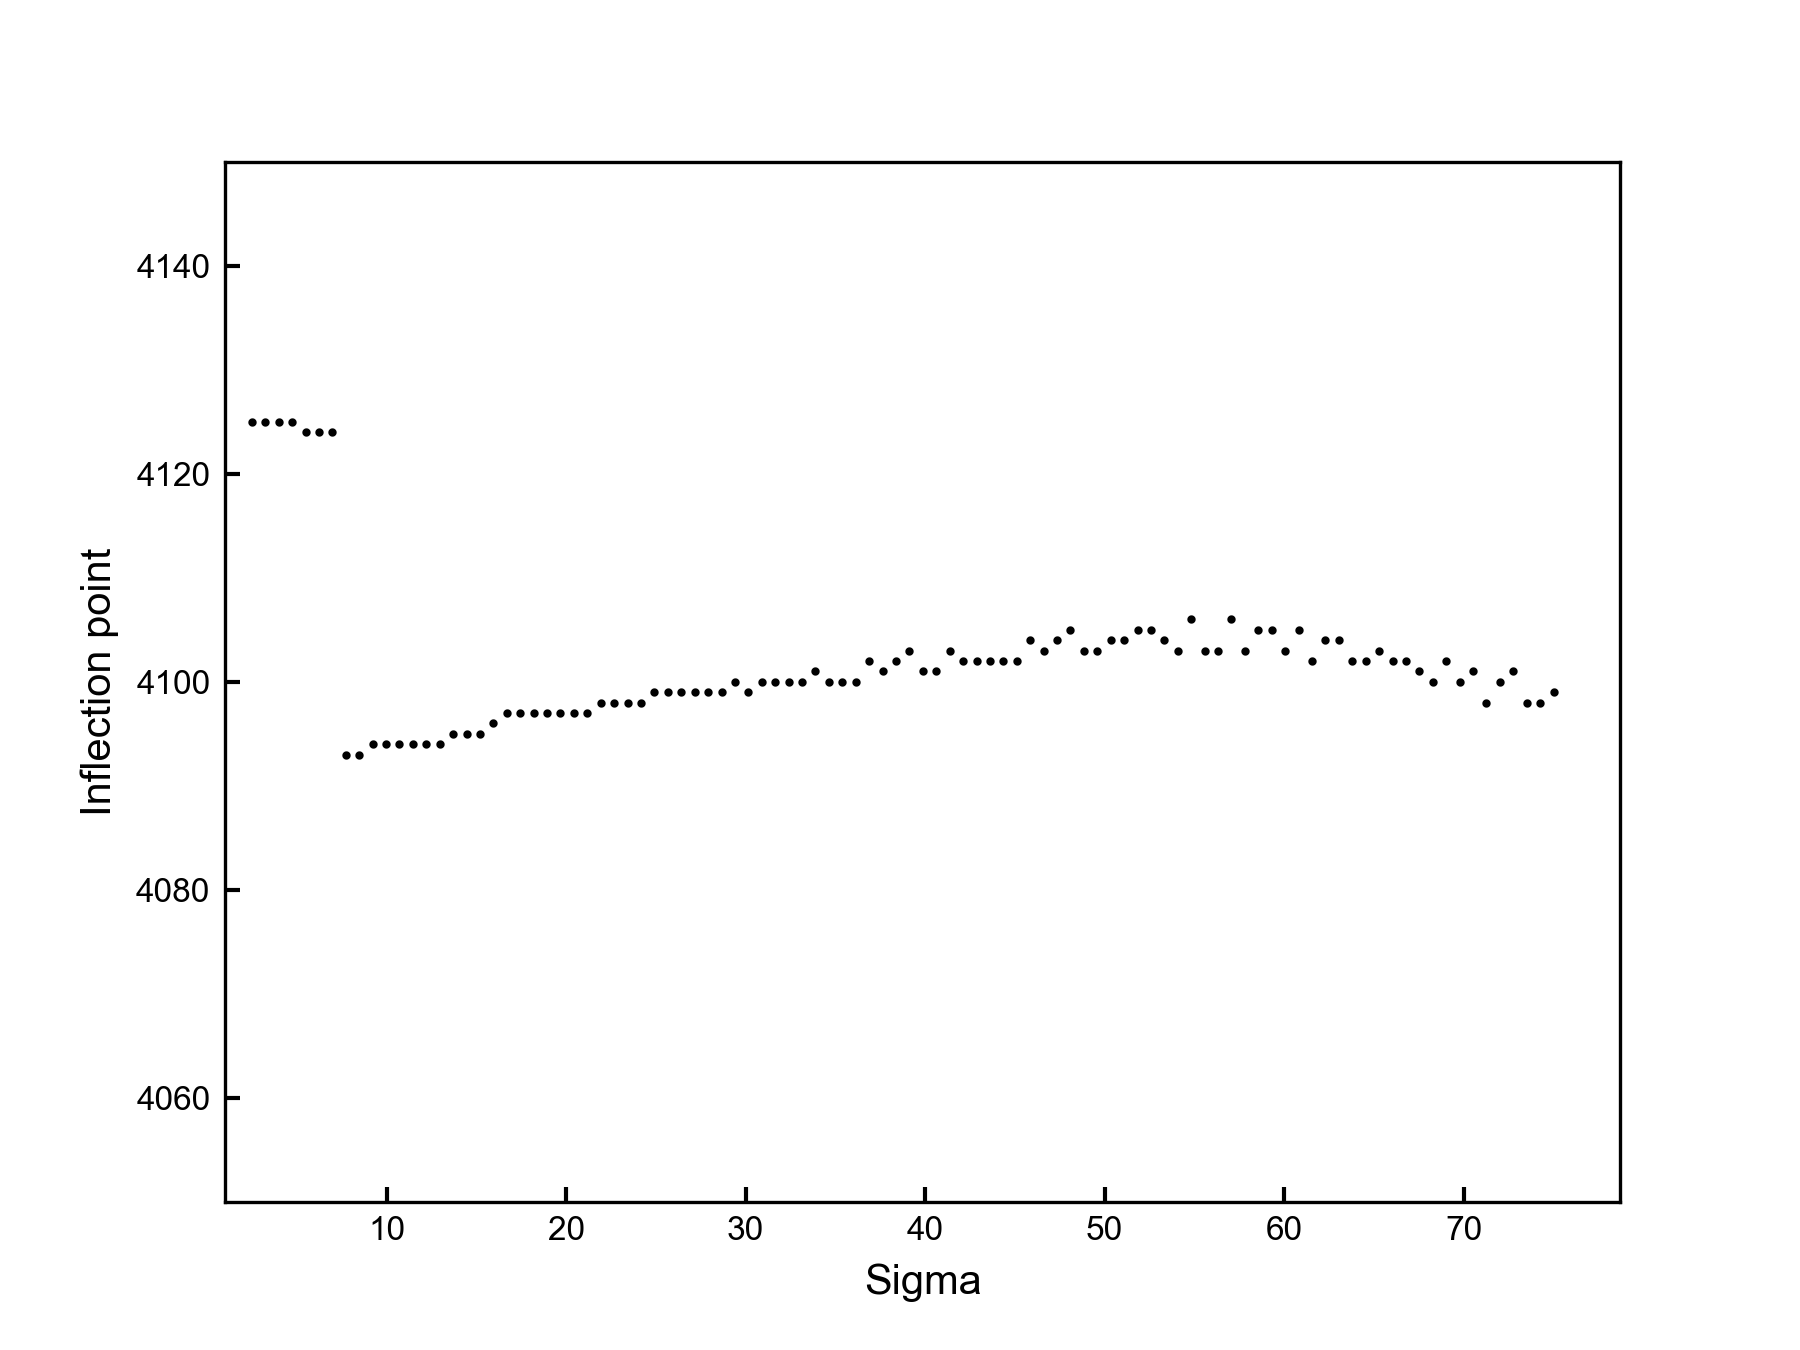

In [487]:
def get_grad_with_variousSigma():

    # 微分するxの値
    x = data["load_data"]["temperature"]["top [degree]"].copy()

    # 時間データ
    t = np.arange(x.shape[0])

    # 微分する範囲
    tlim = (3800,4300)

    # sigmaの範囲
    sigmalim = (1, 75)

    # 表示するグラフ
    switch = 2

    # 時系列データを出力する際のsigmaの値
    sigma_figure = 1

    # 変曲点の範囲 (optional)
    iplim = (4050,4150)

    if True: # Main
        """更新履歴
        * 2025/08/26: 作成
        """
        
        # mask
        mask = np.ones(t.shape).astype(np.bool_)
        mask[t < tlim[0]] = False
        mask[t > tlim[1]] = False

        # 微分
        sigma = np.linspace(*sigmalim,100)
        filtered = []
        gradient = []
        argmax = []
        for s in sigma:
            # フィルタリング
            x_filtered = sp.ndimage.gaussian_filter1d(
                x[mask],
                sigma = s
            )
            filtered.append(x_filtered)

            # 微分する
            grad = np.gradient(np.gradient(x_filtered, t[mask]), t[mask])
            gradient.append(grad)

            # 最大値を求める
            argmax.append(t[mask][np.argmax(grad)])

        # # figure作成
        fig, ax = plt.subplots()
        size_inches = (6,4.5)
        fig.set_size_inches(size_inches)
        fig.set_dpi(300)

        # plot
        if switch == 0:
            index = np.argmin(np.abs(sigma - sigma_figure))
            ax.plot(
                t[mask],
                filtered[index],
                lw = 1,
                c = "0",
            )
            ax.set_title("sigma = {}".format(sigma[index]), loc = "left")
            ax.set_xlabel("Time [s]", fontsize = 10)
            ax.set_ylabel("x", fontsize = 10)
        elif switch == 1:
            ax.plot(
                t[mask],
                gradient[np.argmin(np.abs(sigma - s))],
                lw = 1,
                c = "0",
            )
            ax.set_title("sigma = {}".format(sigma[np.argmin(np.abs(sigma - sigma_figure))]))
            ax.set_xlabel("Time [s]", fontsize = 10)
            ax.set_ylabel("D2x")
        elif switch == 2:
            ax.plot(
                sigma,
                argmax,
                lw = 0,
                marker = "o",
                ms = 1,
                c = "0"
            )
            ax.set_xlabel("Sigma", fontsize = 10)
            ax.set_ylabel("Inflection point", fontsize = 10)
            ax.set_xlim((1,ax.get_xlim()[1]))
            if "iplim" in locals():
                ax.set_ylim(iplim) # type: ignore

        # 出力等
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        plt.close()
        key = sys._getframe().f_code.co_name
        imgfilename = os.path.join(cachedir, key + ".png")
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
        pdffilename = os.path.join(cachedir, key + ".pdf")
        plt.savefig(pdffilename)
        logger.debug("[Save pdf]: " + os.path.abspath(pdffilename))
        plt.close()
        display(Image(filename = imgfilename, width = size_inches[0]*100))

    return
get_grad_with_variousSigma()
del get_grad_with_variousSigma

DEBUG      2025-08-26 18:59:04,253 [3350698741.py:110] [Save fig]: c:\Users\okaza\Documents\Friction\.cache\get_grad_with_variousSigma.png
DEBUG      2025-08-26 18:59:04,256 [3350698741.py:113] [Save pdf]: c:\Users\okaza\Documents\Friction\.cache\get_grad_with_variousSigma.pdf


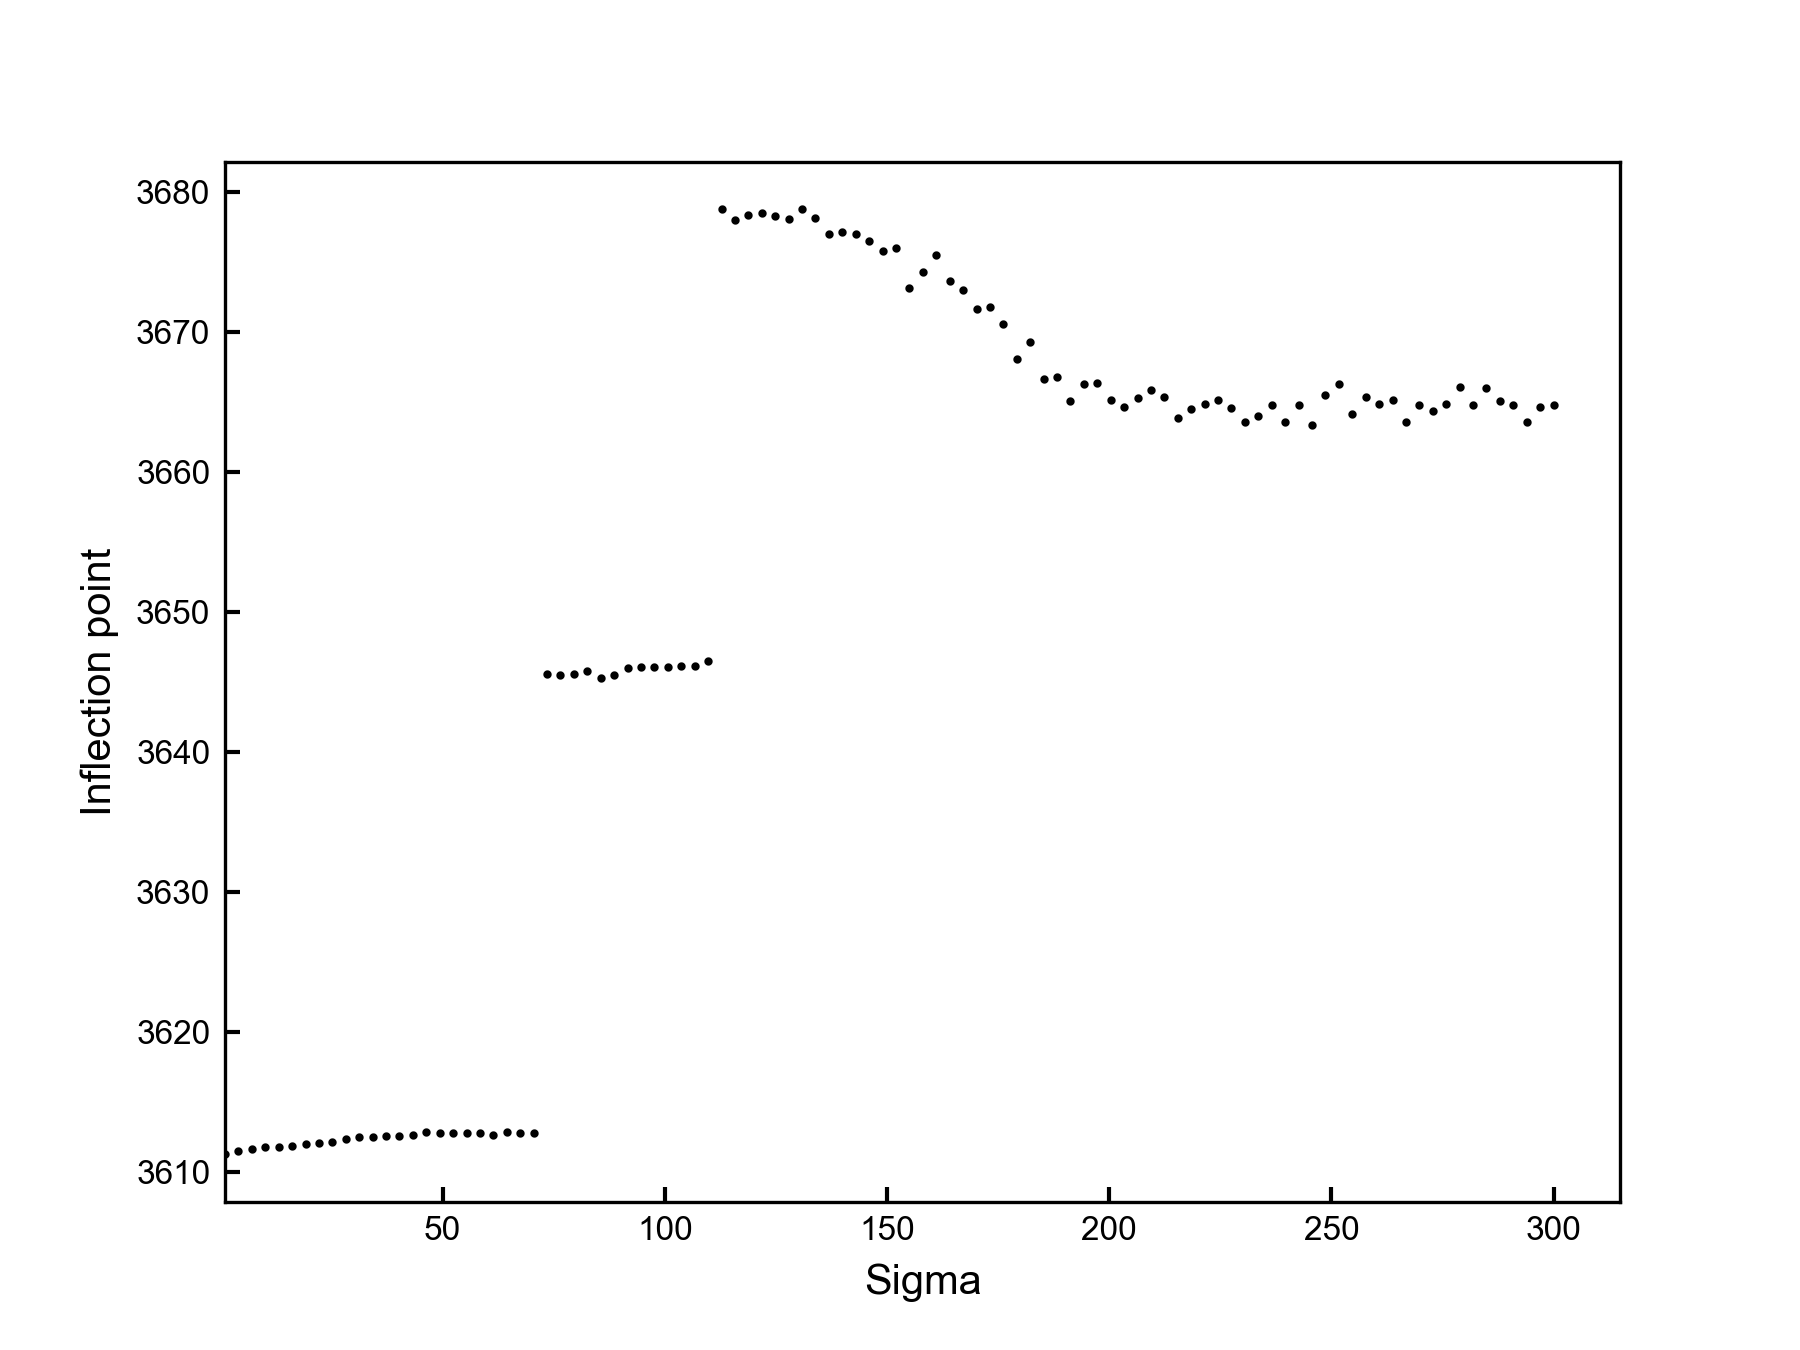

In [484]:
def get_grad_with_variousSigma():

    # 微分するxの値
    x = data["load_data"]["mechanical"]["EFT_0008_0001"]["Normal Force [kN]"].copy()
    x *= -1

    # 時間データ
    t = np.arange(x.shape[0]) / 10

    # 微分する範囲
    tlim = (3300,3800)

    # sigmaの範囲
    sigmalim = (1, 300)

    # 表示するグラフ
    switch = 2

    # 時系列データを出力する際のsigmaの値
    sigma_figure = 150

    # 変曲点の範囲 (optional)
    # iplim = (3650,3680)

    if True: # Main
        """更新履歴
        * 2025/08/26: 作成
        """
        
        # mask
        mask = np.ones(t.shape).astype(np.bool_)
        mask[t < tlim[0]] = False
        mask[t > tlim[1]] = False

        # 微分
        sigma = np.linspace(*sigmalim,100)
        filtered = []
        gradient = []
        argmax = []
        for s in sigma:
            # フィルタリング
            x_filtered = sp.ndimage.gaussian_filter1d(
                x[mask],
                sigma = s
            )
            filtered.append(x_filtered)

            # 微分する
            grad = np.gradient(np.gradient(x_filtered, t[mask]), t[mask])
            gradient.append(grad)

            # 最大値を求める
            argmax.append(t[mask][np.argmax(grad)])

        # # figure作成
        fig, ax = plt.subplots()
        size_inches = (6,4.5)
        fig.set_size_inches(size_inches)
        fig.set_dpi(300)

        # plot
        if switch == 0:
            index = np.argmin(np.abs(sigma - sigma_figure))
            ax.plot(
                t[mask],
                filtered[index],
                lw = 1,
                c = "0",
            )
            ax.set_title("sigma = {}".format(sigma[index]), loc = "left")
            ax.set_xlabel("Time [s]", fontsize = 10)
            ax.set_ylabel("x", fontsize = 10)
        elif switch == 1:
            ax.plot(
                t[mask],
                gradient[np.argmin(np.abs(sigma - s))],
                lw = 1,
                c = "0",
            )
            ax.set_title("sigma = {}".format(sigma[np.argmin(np.abs(sigma - sigma_figure))]))
            ax.set_xlabel("Time [s]", fontsize = 10)
            ax.set_ylabel("D2x")
        elif switch == 2:
            ax.plot(
                sigma,
                argmax,
                lw = 0,
                marker = "o",
                ms = 1,
                c = "0"
            )
            ax.set_xlabel("Sigma", fontsize = 10)
            ax.set_ylabel("Inflection point", fontsize = 10)
            ax.set_xlim((1,ax.get_xlim()[1]))
            if "iplim" in locals():
                ax.set_ylim(iplim) # type: ignore

        # 出力等
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        plt.close()
        key = sys._getframe().f_code.co_name
        imgfilename = os.path.join(cachedir, key + ".png")
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
        pdffilename = os.path.join(cachedir, key + ".pdf")
        plt.savefig(pdffilename)
        logger.debug("[Save pdf]: " + os.path.abspath(pdffilename))
        plt.close()
        display(Image(filename = imgfilename, width = size_inches[0]*100))

    return
get_grad_with_variousSigma()
del get_grad_with_variousSigma

DEBUG      2025-08-26 18:21:31,751 [3676052100.py:80] [Save fig]: c:\Users\okaza\Documents\Friction\.cache\detect_timing.png
DEBUG      2025-08-26 18:21:31,754 [3676052100.py:83] [Save pdf]: c:\Users\okaza\Documents\Friction\.cache\detect_timing.pdf


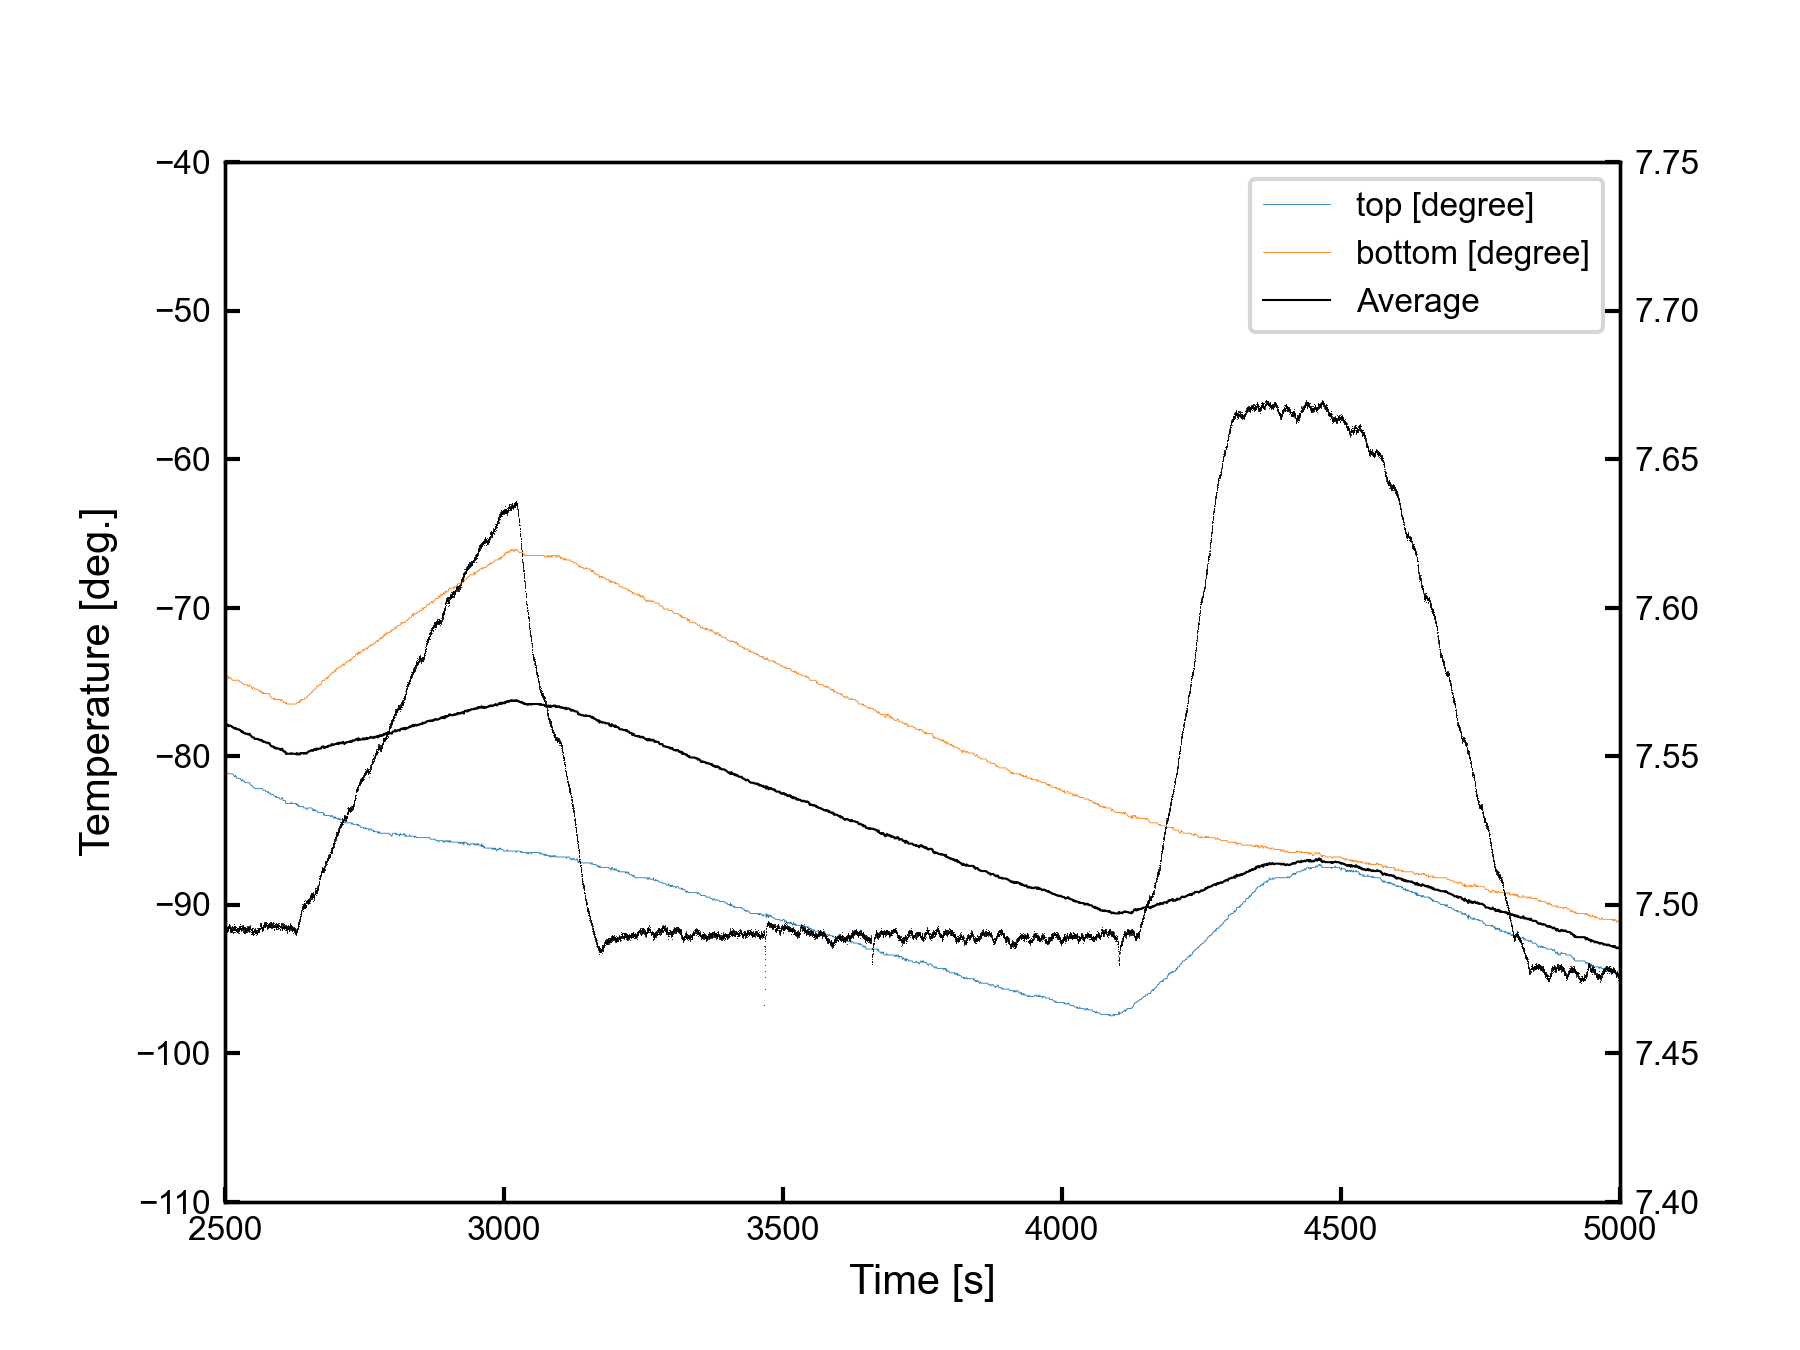

In [395]:
def detect_timing():
    
    # ax_temp
    xlim = (1000, 6000)
    xlim = (2500, 5000)
    # xlim = (2500, 3000)
    ylim_temp = (-110, -40)
    # ylim_temp = (-80, -60)

    # ax_mechanic
    aset1 = 490
    ylim_mechanic = (7.25,7.75)
    ylim_mechanic = (7.4,7.75)


    if True: # Main
        # データ作成
        time = np.arange(data["load_data"]["temperature"]["top [degree]"].shape[0])
        temperature = data["load_data"]["temperature"]["bottom [degree]"].copy()
        nf = data["load_data"]["mechanical"]["EFT_0008_0001"]["Normal Force [kN]"].copy() * -1
        time1 = np.arange(nf.shape[0]) / 10 + aset1

        # # figure作成
        fig, ax_temp = plt.subplots()
        ax_mechanic = ax_temp.twinx()
        size_inches = (6,4.5)
        fig.set_size_inches(size_inches)
        fig.set_dpi(300)

        # temperature
        keys = list(data["load_data"]["temperature"].keys())
        colors = plt.get_cmap("tab10")
        ave = np.zeros(data["load_data"]["temperature"]["top [degree]"].shape)
        for i in range(2):
            ax_temp.plot(
                time,
                data["load_data"]["temperature"][keys[i]],
                c = colors(i),
                lw = 0.2,
                label = keys[i],
            )
            ave += data["load_data"]["temperature"][keys[i]]
        ax_temp.plot(
            time,
            ave/2,
            lw = 0.5,
            c = "0",
            label = "Average"
        )
        ax_temp.set_ylabel("Temperature [deg.]", fontsize = 10)
        ax_temp.set_xlabel("Time [s]", fontsize = 10)
        ax_temp.set_ylim(ylim_temp)
        ax_temp.set_xlim(xlim)
        ax_temp.legend()

        # mechanic
        ax_mechanic.plot(
            time1,
            nf,
            lw = 0,
            c = "0",
            marker = "o",
            ms = 0.2,
            mew = 0,
        )
        ax_mechanic.set_ylim(ylim_mechanic)  

        # 出力等
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        plt.close()
        key = sys._getframe().f_code.co_name
        imgfilename = os.path.join(cachedir, key + ".png")
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
        pdffilename = os.path.join(cachedir, key + ".pdf")
        plt.savefig(pdffilename)
        logger.debug("[Save pdf]: " + os.path.abspath(pdffilename))
        plt.close()
        display(Image(filename = imgfilename, width = size_inches[0]*100))

    return
detect_timing()
del detect_timing

## 出力

剪断方向の剛性率を計算します。

DEBUG      2025-08-29 14:49:05,251 [1481539660.py:71] [Save fig]: c:\Users\okaza\Documents\Friction\.cache\det_stiffness.png


38.03338014809493 1.2519468082334306
[0.05 0.4 ] [ 6.89394681 11.38794681]


DEBUG      2025-08-29 14:49:05,852 [1481539660.py:74] [Save pdf]: c:\Users\okaza\Documents\Friction\.cache\det_stiffness.pdf


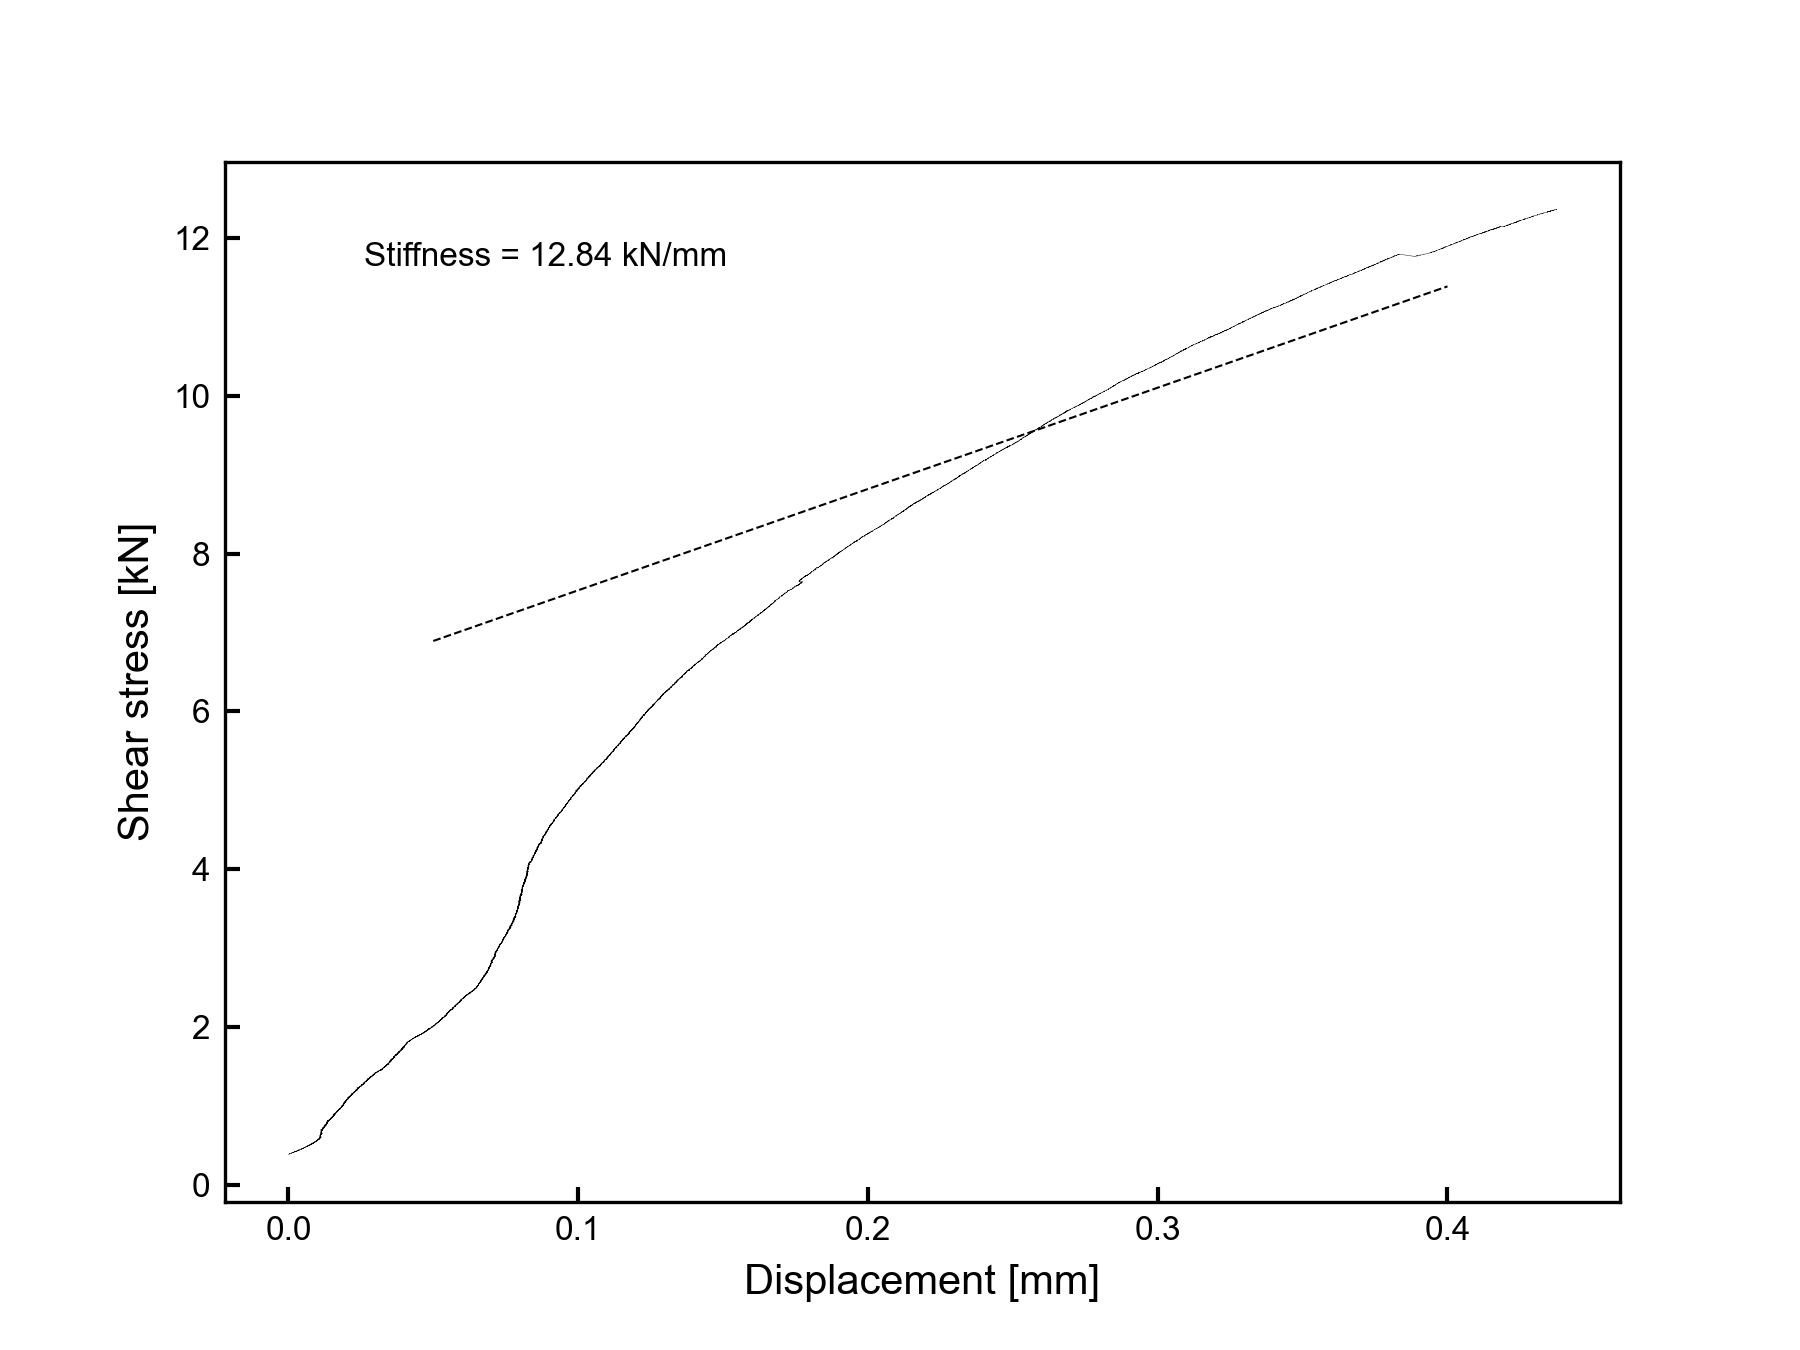

INFO       2025-08-29 14:49:05,882 [1481539660.py:80] [Add variables]: key = det_stiffness


<class 'dict'>  (size = 3.58 MB)
├── load_data
│   ├── mechanical
│   │   ├── EFT_0008_0000
│   │   │   ├── Time [s] <class 'numpy.ndarray'> [shape = (486,)]
│   │   │   ├── Normal Force [kN] <class 'numpy.ndarray'> [shape = (486,)]
│   │   │   ├── Normal Displacement [mm] <class 'numpy.ndarray'> [shape = (486,)]
│   │   │   ├── Shear Displacement [mm] <class 'numpy.ndarray'> [shape = (486,)]
│   │   │   └── Shear Force [kN] <class 'numpy.ndarray'> [shape = (486,)]
│   │   ├── EFT_0008_0001
│   │   │   ├── Time [s] <class 'numpy.ndarray'> [shape = (47484,)]
│   │   │   ├── Normal Force [kN] <class 'numpy.ndarray'> [shape = (47484,)]
│   │   │   ├── Normal Displacement [mm] <class 'numpy.ndarray'> [shape = (47484,)]
│   │   │   ├── Shear Displacement [mm] <class 'numpy.ndarray'> [shape = (47484,)]
│   │   │   └── Shear Force [kN] <class 'numpy.ndarray'> [shape = (47484,)]
│   │   └── EFT_0008_0002
│   │       ├── Time [s] <class 'numpy.ndarray'> [shape = (41908,)]
│   │       ├── Normal

In [109]:
def det_stiffness():


    d = data["load_data"]["mechanical"]["EFT_0008_0002"]


    drange = (0,29000)
    drange = (0,14000)
    d0 = d["Shear Displacement [mm]"][0]

    nf = d["Shear Force [kN]"][drange[0]:drange[1]].copy() * -1
    mask = np.ones(nf.shape).astype(np.bool_)
    mask[nf < 5] = False
    mask[nf > 7] = False
    x = (d["Shear Displacement [mm]"][drange[0]:drange[1]]-d0)[mask]
    y = nf[mask]
    cov = np.cov(
        x,
        y
    )
    plt.plot(x,y)
    a = cov[0,1]/cov[0,0]
    b = np.mean(y) - a*np.mean(x)
    print(a,b)
    a = 12.84
    b += 5
    xp = np.array([0.05,0.4])
    yp = a*xp + b
    print(xp,yp)

    # # figure作成
    fig, ax = plt.subplots()
    size_inches = (6,4.5)
    fig.set_size_inches(size_inches)
    fig.set_dpi(300)

    ax.plot(
        d["Shear Displacement [mm]"][drange[0]:drange[1]]-d0,
        # d["Time [s]"],
        d["Shear Force [kN]"][drange[0]:drange[1]]*-1,
        lw = 0.1,
        c = "0"
    )
    ax.plot(
        xp,yp,
        lw = 0.5,
        ls = "dashed",
        c = "0"
    )
    ax.text(
        0.1,0.9,
        "Stiffness = {:.2f} kN/mm".format(a),
        transform = ax.transAxes
    )

    ax.set_xlabel("Displacement [mm]", fontsize = 10)
    ax.set_ylabel("Shear stress [kN]", fontsize = 10)

    # 出力等
    fig.canvas.draw()
    img = im.frombuffer(
        mode = "RGBA",
        size = fig.canvas.get_width_height(),
        data = fig.canvas.buffer_rgba(), # type: ignore
        decoder_name = "raw"
    )
    plt.close()
    key = sys._getframe().f_code.co_name
    imgfilename = os.path.join(cachedir, key + ".png")
    img.save(imgfilename)
    logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
    pdffilename = os.path.join(cachedir, key + ".pdf")
    plt.savefig(pdffilename)
    logger.debug("[Save pdf]: " + os.path.abspath(pdffilename))
    plt.close()
    display(Image(filename = imgfilename, width = size_inches[0]*100))

    data[key] = dict()
    data[key]["Stiffness [kN/mm]"] = a
    logger.info("[Add variables]: key = {}".format(key))
    dict_tree(data)

    return
det_stiffness()
del det_stiffness

DEBUG      2025-08-29 19:53:55,647 [2853528524.py:61] [Save fig]: c:\Users\okaza\Documents\Friction\.cache\temperature.png
DEBUG      2025-08-29 19:53:55,740 [2853528524.py:64] [Save pdf]: c:\Users\okaza\Documents\Friction\.cache\temperature.pdf


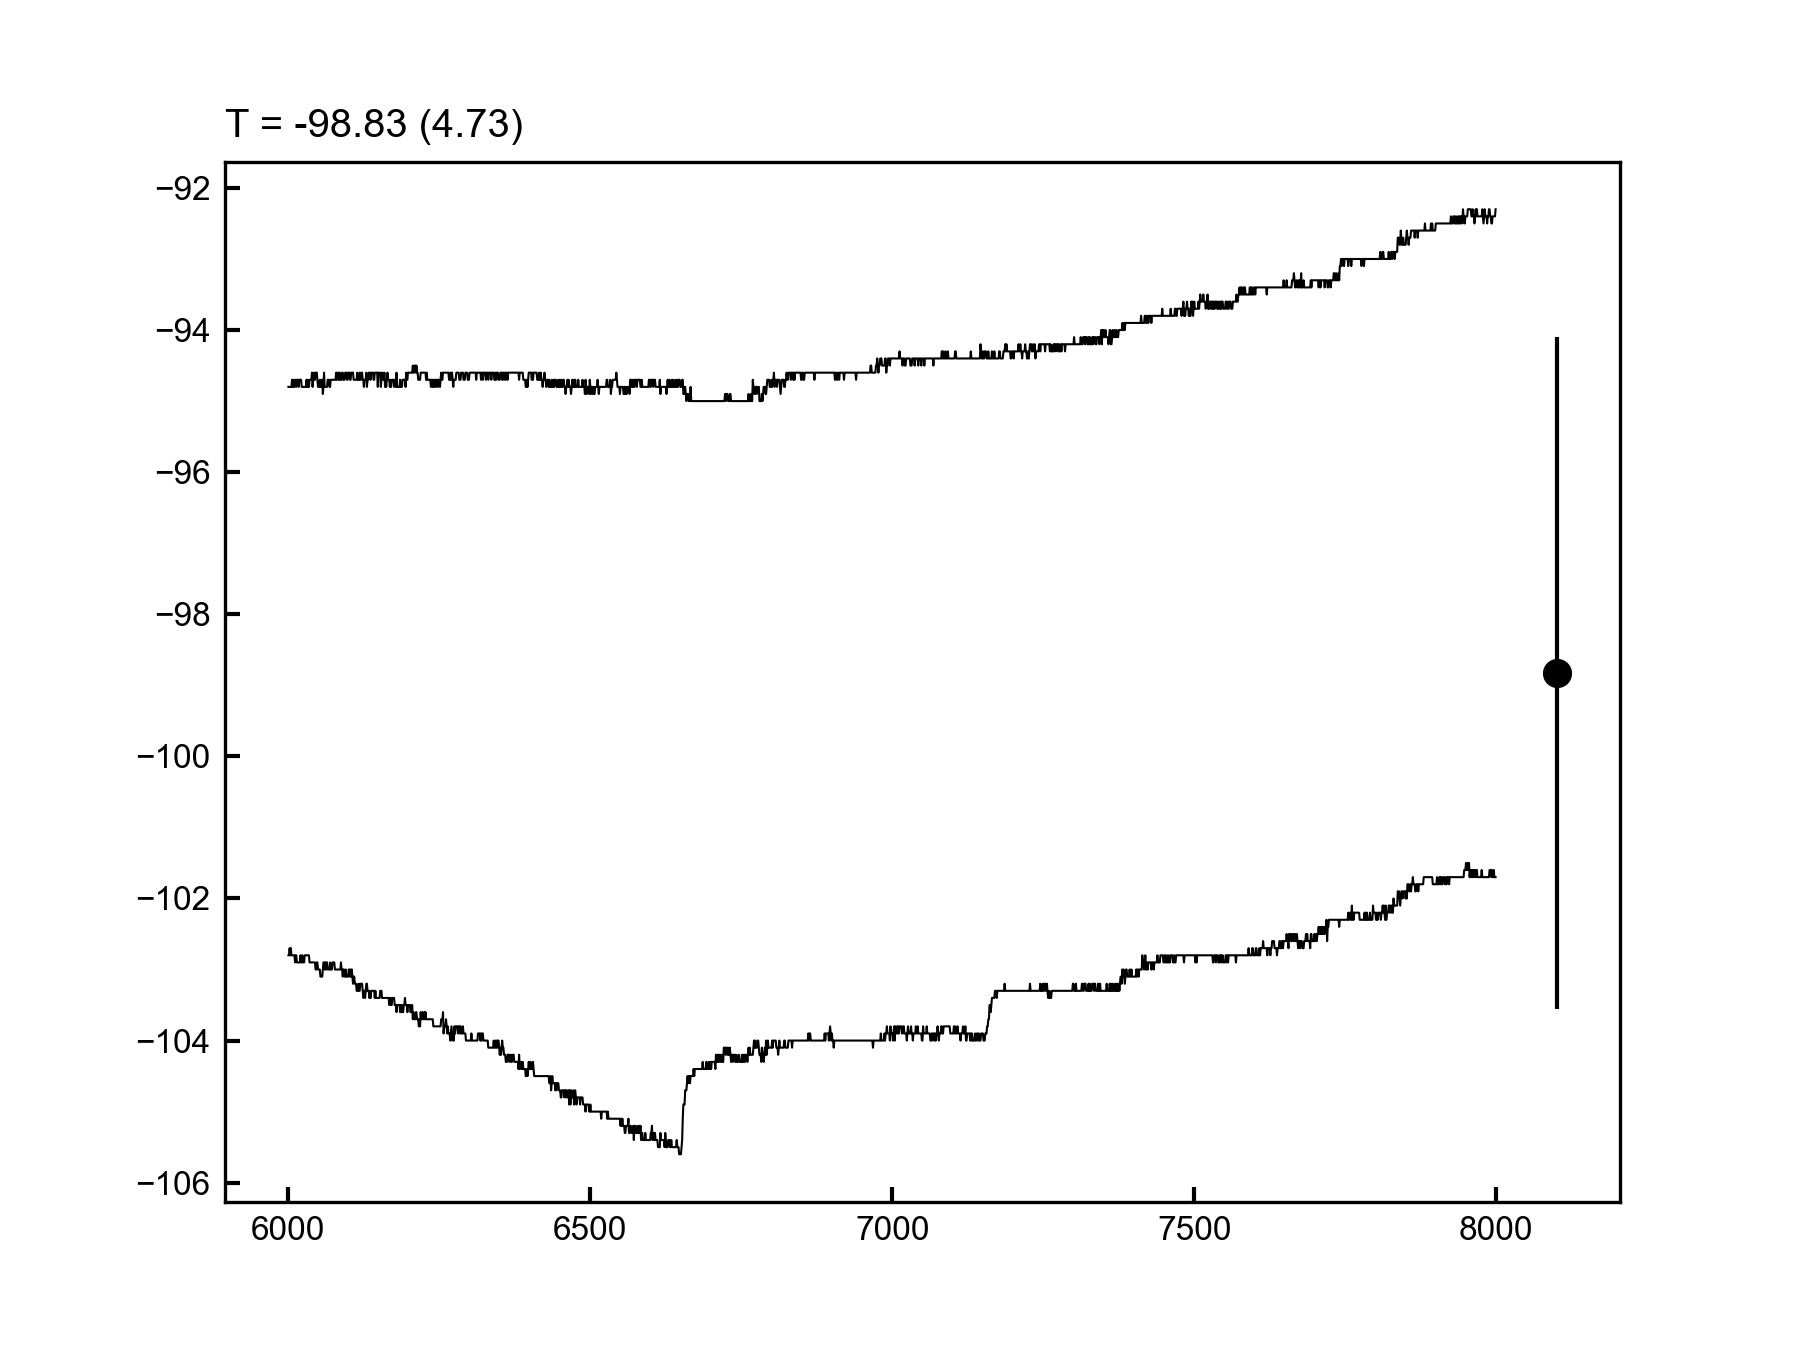

In [246]:
def temperature():

    t1 = data["load_data"]["temperature"]["top [degree]"]
    t2 = data["load_data"]["temperature"]["bottom [degree]"]
    t = np.arange(t1.shape[0])
    temp = np.vstack([t1,t2])

    trange = (6000,8000)

    x = t[trange[0]:trange[1]]
    y = temp.T[trange[0]:trange[1]].T

    ave = np.mean(y, axis = 1)
    std = np.std(y, axis = 1, ddof = 1)
    ave_center = np.mean(ave)
    ave_dif = np.abs(ave[0]-ave[1])/2
    std_center = np.mean(std)
    ave_err = np.sqrt(np.square(ave_dif) + np.square(std_center))


    # # figure作成
    fig, ax = plt.subplots()
    size_inches = (6,4.5)
    fig.set_size_inches(size_inches)
    fig.set_dpi(300)

    for yp in y:
        ax.plot(
            x,
            yp,
            lw = 0.5,
            c = "0"
        )

    ax.errorbar(
        x = 8100,
        y = ave_center,
        yerr = ave_err,
        lw = 0,
        fmt = "o",
        ms = 6,
        c = "0",
        elinewidth=1
    )
    ax.set_title(
        "T = {:.2f} ({:.2f})".format(ave_center, ave_err),
        loc = "left"
    )

    # 出力等
    fig.canvas.draw()
    img = im.frombuffer(
        mode = "RGBA",
        size = fig.canvas.get_width_height(),
        data = fig.canvas.buffer_rgba(), # type: ignore
        decoder_name = "raw"
    )
    key = sys._getframe().f_code.co_name
    imgfilename = os.path.join(cachedir, key + ".png")
    img.save(imgfilename)
    logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
    pdffilename = os.path.join(cachedir, key + ".pdf")
    plt.savefig(pdffilename)
    logger.debug("[Save pdf]: " + os.path.abspath(pdffilename))
    plt.close()
    display(Image(filename = imgfilename, width = size_inches[0]*100))


    return
temperature()
del temperature

DEBUG      2025-08-29 19:43:41,446 [4026154719.py:40] [Save fig]: c:\Users\okaza\Documents\Friction\.cache\make_figure.png
DEBUG      2025-08-29 19:43:41,533 [4026154719.py:43] [Save pdf]: c:\Users\okaza\Documents\Friction\.cache\make_figure.pdf


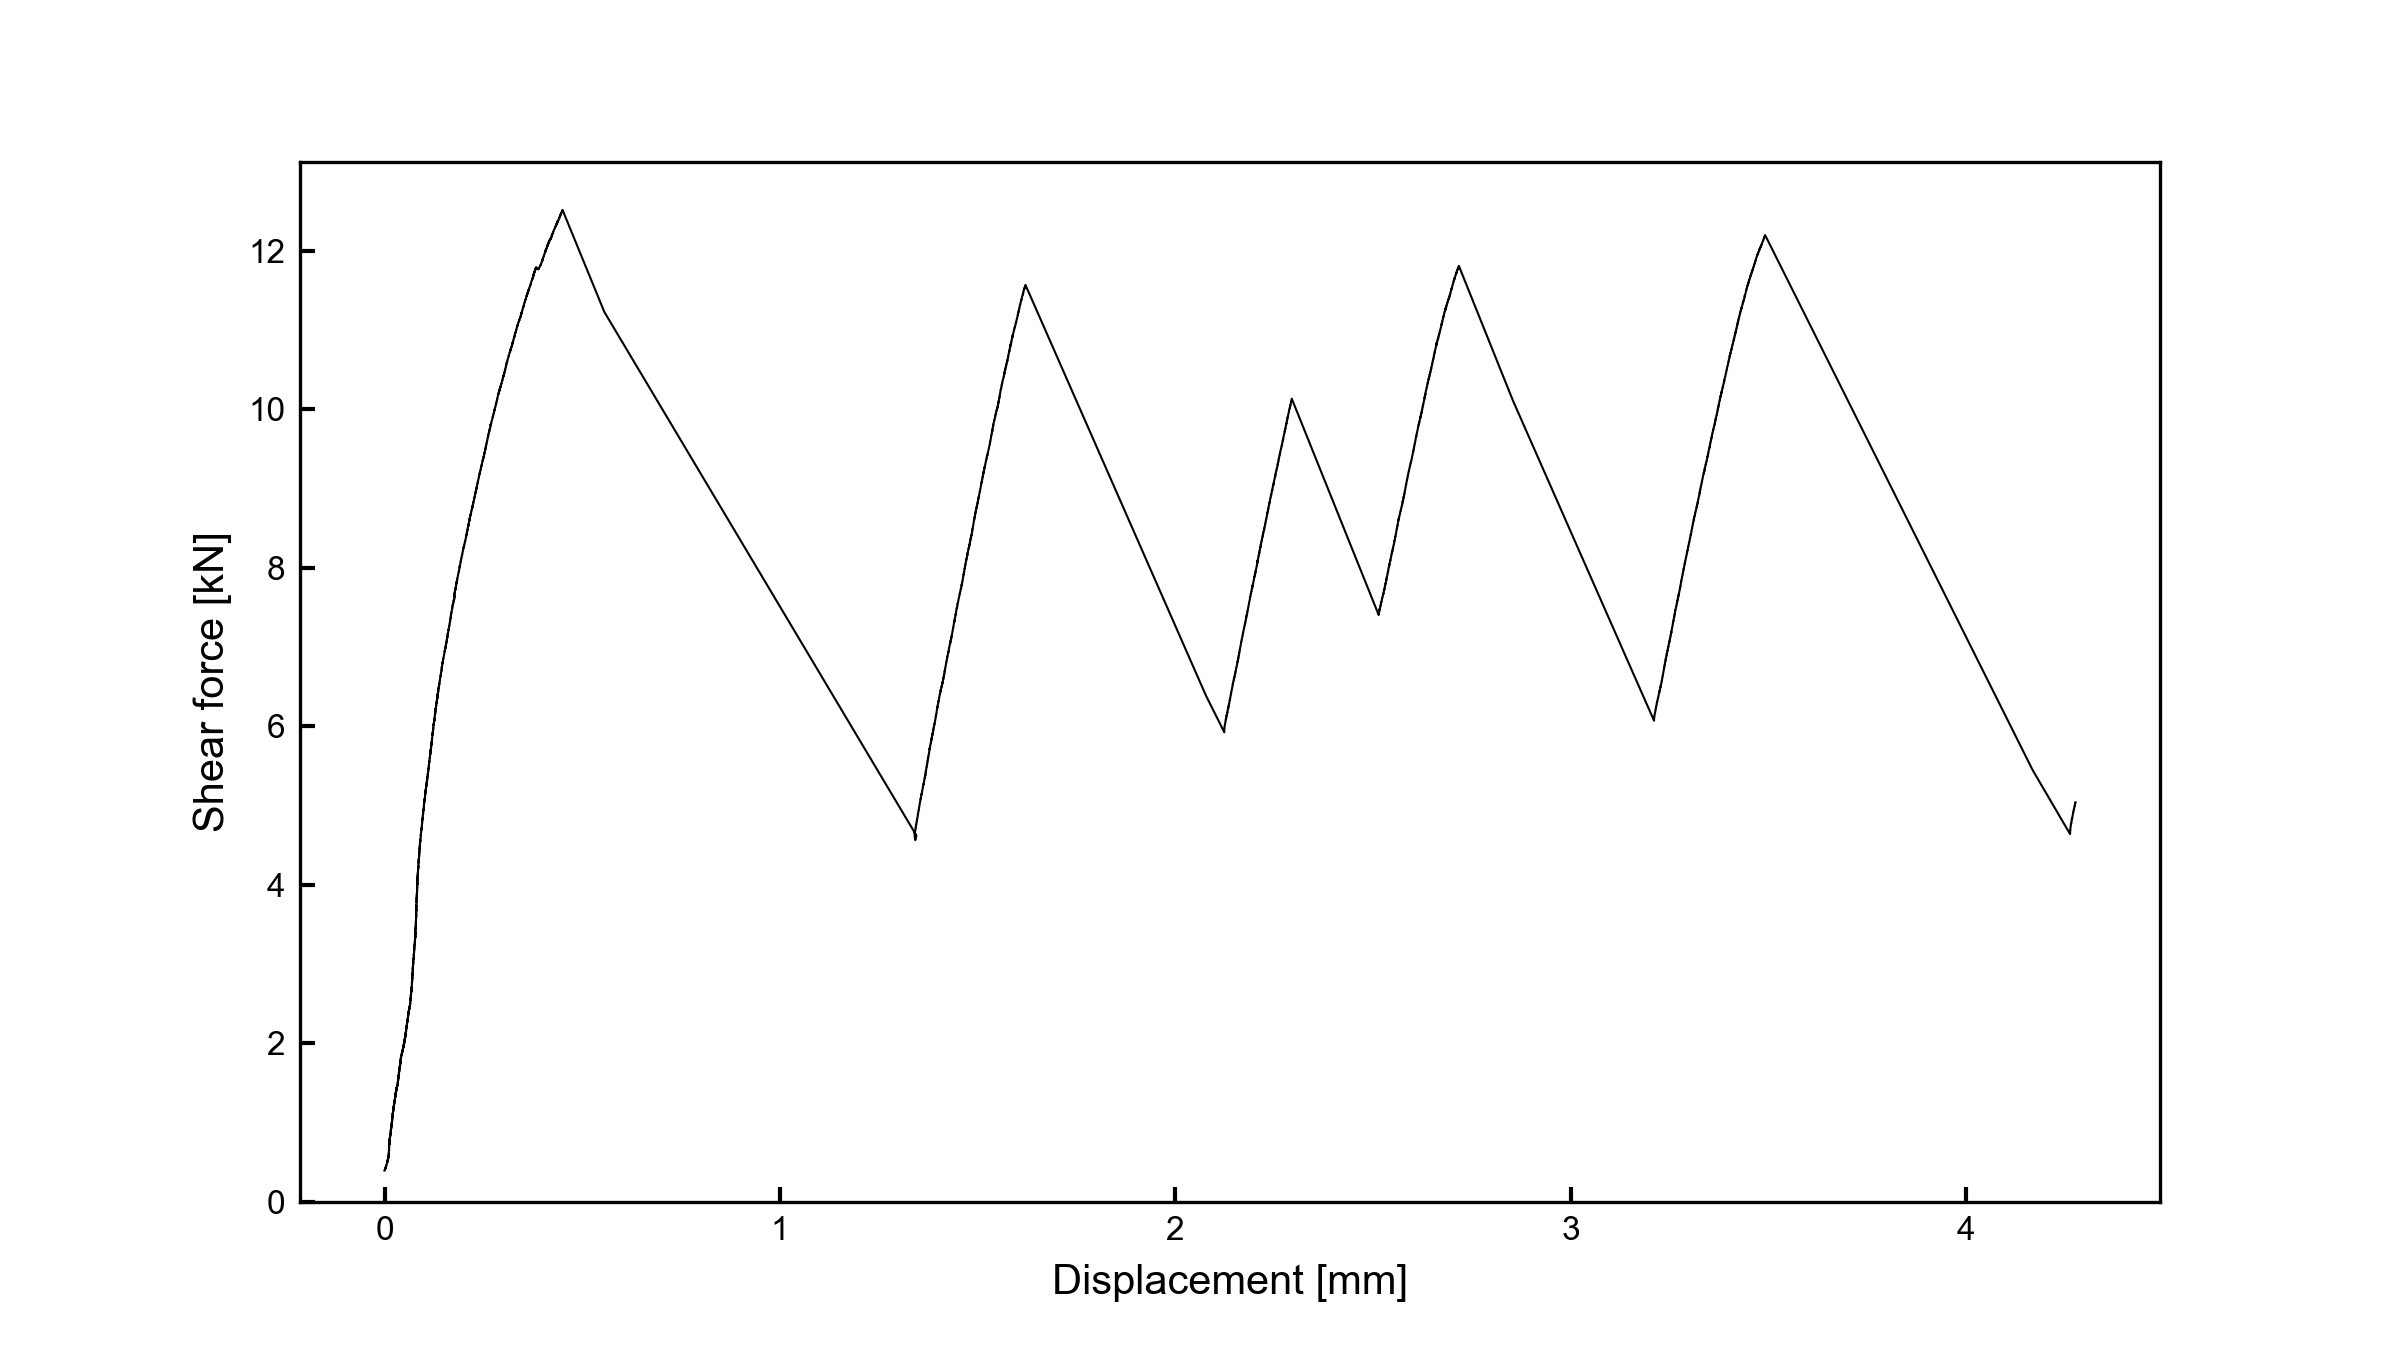

In [ ]:
def make_figure():

    d = data["load_data"]["mechanical"]["EFT_0008_0002"]

    drange = (0,29000)
    # x = d["Time [s]"][drange[0]:drange[1]].copy()
    x = d["Shear Displacement [mm]"][drange[0]:drange[1]].copy()
    y = d["Shear Force [kN]"][drange[0]:drange[1]].copy()*-1
    # x -= y/data["det_stiffness"]["Stiffness [kN/mm]"]
    # x -= y/12.84
    x -= x[0]    

    # # figure作成
    fig, ax = plt.subplots()
    size_inches = (8,4.5)
    fig.set_size_inches(size_inches)
    fig.set_dpi(300)

    ax.plot(
        x,
        y,
        lw = 0.5,
        c = "0",
    )
    ax.set_xlabel("Displacement [mm]", fontsize = 10)
    ax.set_ylabel("Shear force [kN]", fontsize = 10)
    ax.set_ylim((0,ax.get_ylim()[1]))

    # 出力等
    fig.canvas.draw()
    img = im.frombuffer(
        mode = "RGBA",
        size = fig.canvas.get_width_height(),
        data = fig.canvas.buffer_rgba(), # type: ignore
        decoder_name = "raw"
    )
    key = sys._getframe().f_code.co_name
    imgfilename = os.path.join(cachedir, key + ".png")
    img.save(imgfilename)
    logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
    pdffilename = os.path.join(cachedir, key + ".pdf")
    plt.savefig(pdffilename)
    logger.debug("[Save pdf]: " + os.path.abspath(pdffilename))
    plt.close()
    display(Image(filename = imgfilename, width = size_inches[0]*100))

    return
make_figure()
del make_figure

Stick-slipの解析

DEBUG      2025-08-29 15:40:01,352 [2333575391.py:50] [Save fig]: c:\Users\okaza\Documents\Friction\.cache\anl_stickslip.png


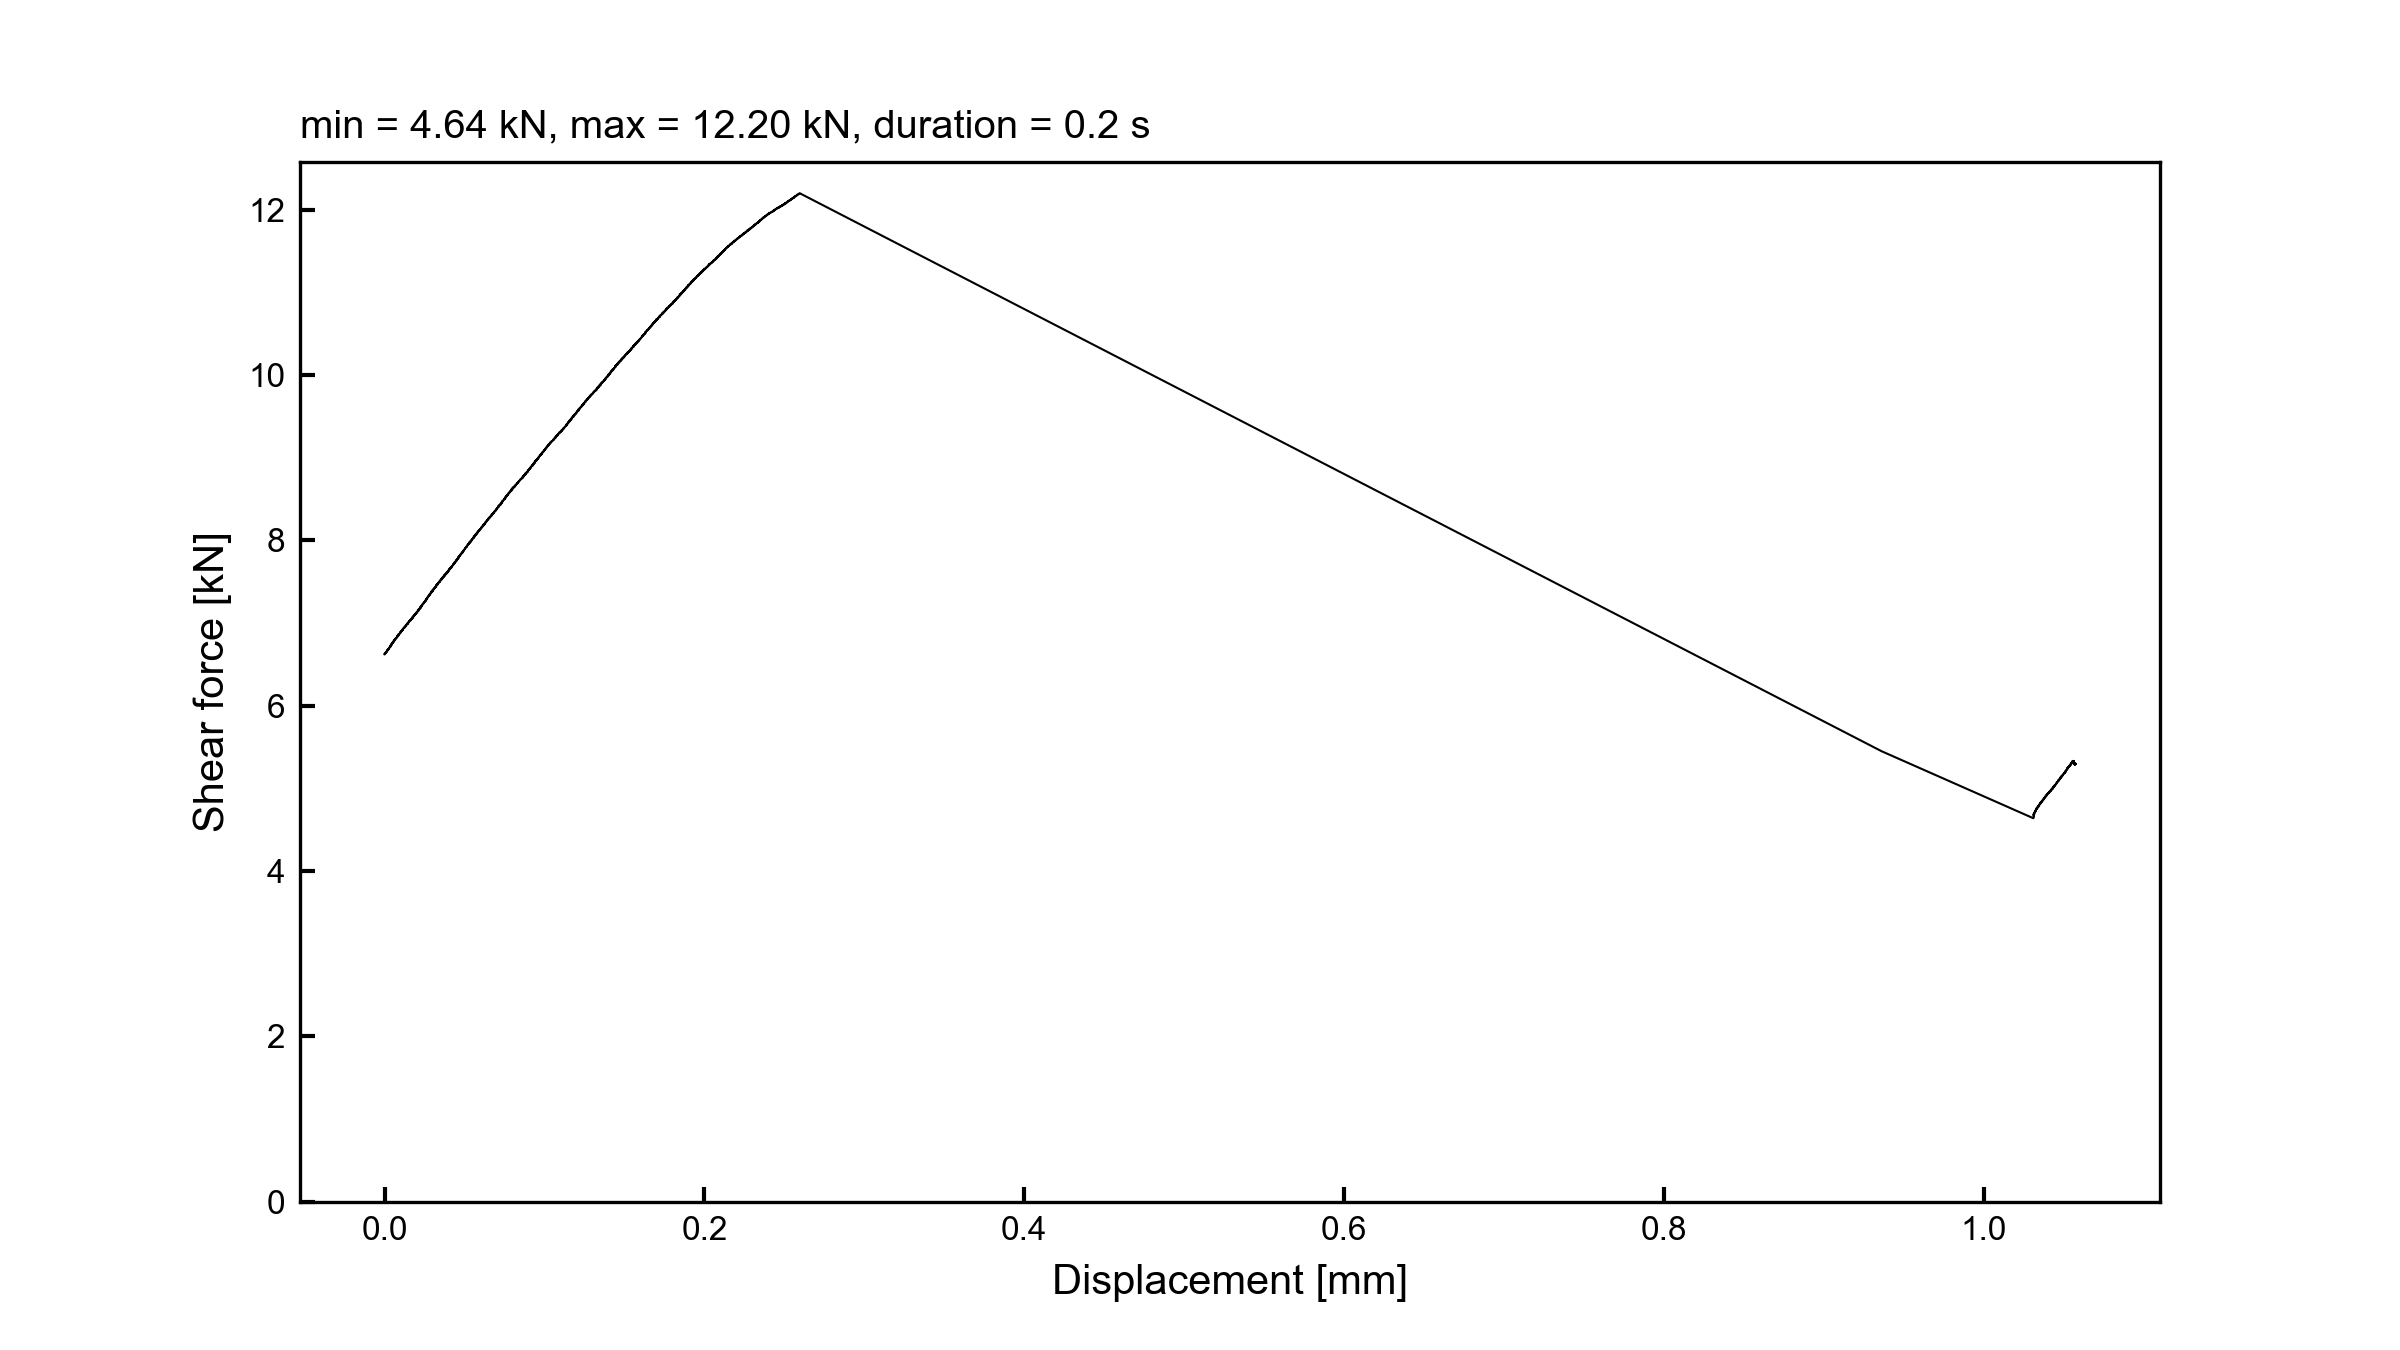

In [146]:
def anl_stickslip():


    d = data["load_data"]["mechanical"]["EFT_0008_0002"]

    drange = (10000,15000)
    drange = (17000,20000)
    drange = (21000,22500)
    drange = (22500,25000)
    drange = (25000,30000)
    x = d["Shear Displacement [mm]"][drange[0]:drange[1]].copy()
    y = d["Shear Force [kN]"][drange[0]:drange[1]].copy()*-1
    x -= x[0]

    # # figure作成
    fig, ax = plt.subplots()
    size_inches = (8,4.5)
    fig.set_size_inches(size_inches)
    fig.set_dpi(300)

    ax.plot(
        x,
        y,
        lw = 0.5,
        c = "0",
    )
    ax.set_title(
        "min = {:.2f} kN, max = {:.2f} kN, duration = {} s".format(
            y.min(),
            y.max(),
            (np.argmin(y) - np.argmax(y))*0.1
        ),
        loc = "left"
    )
    ax.set_xlabel("Displacement [mm]", fontsize = 10)
    ax.set_ylabel("Shear force [kN]", fontsize = 10)
    ax.set_ylim((0,ax.get_ylim()[1]))

    # 出力等
    fig.canvas.draw()
    img = im.frombuffer(
        mode = "RGBA",
        size = fig.canvas.get_width_height(),
        data = fig.canvas.buffer_rgba(), # type: ignore
        decoder_name = "raw"
    )
    key = sys._getframe().f_code.co_name
    imgfilename = os.path.join(cachedir, key + ".png")
    img.save(imgfilename)
    logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
    # pdffilename = os.path.join(cachedir, key + ".pdf")
    # plt.savefig(pdffilename)
    # logger.debug("[Save pdf]: " + os.path.abspath(pdffilename))
    plt.close()
    display(Image(filename = imgfilename, width = size_inches[0]*100))


    return
anl_stickslip()
del anl_stickslip

DEBUG      2025-08-29 18:47:09,239 [2288201519.py:100] [Save fig]: c:\Users\okaza\Documents\Friction\.cache\nf_sf.png
DEBUG      2025-08-29 18:47:09,347 [2288201519.py:103] [Save pdf]: c:\Users\okaza\Documents\Friction\.cache\nf_sf.pdf


0.5793923925189699


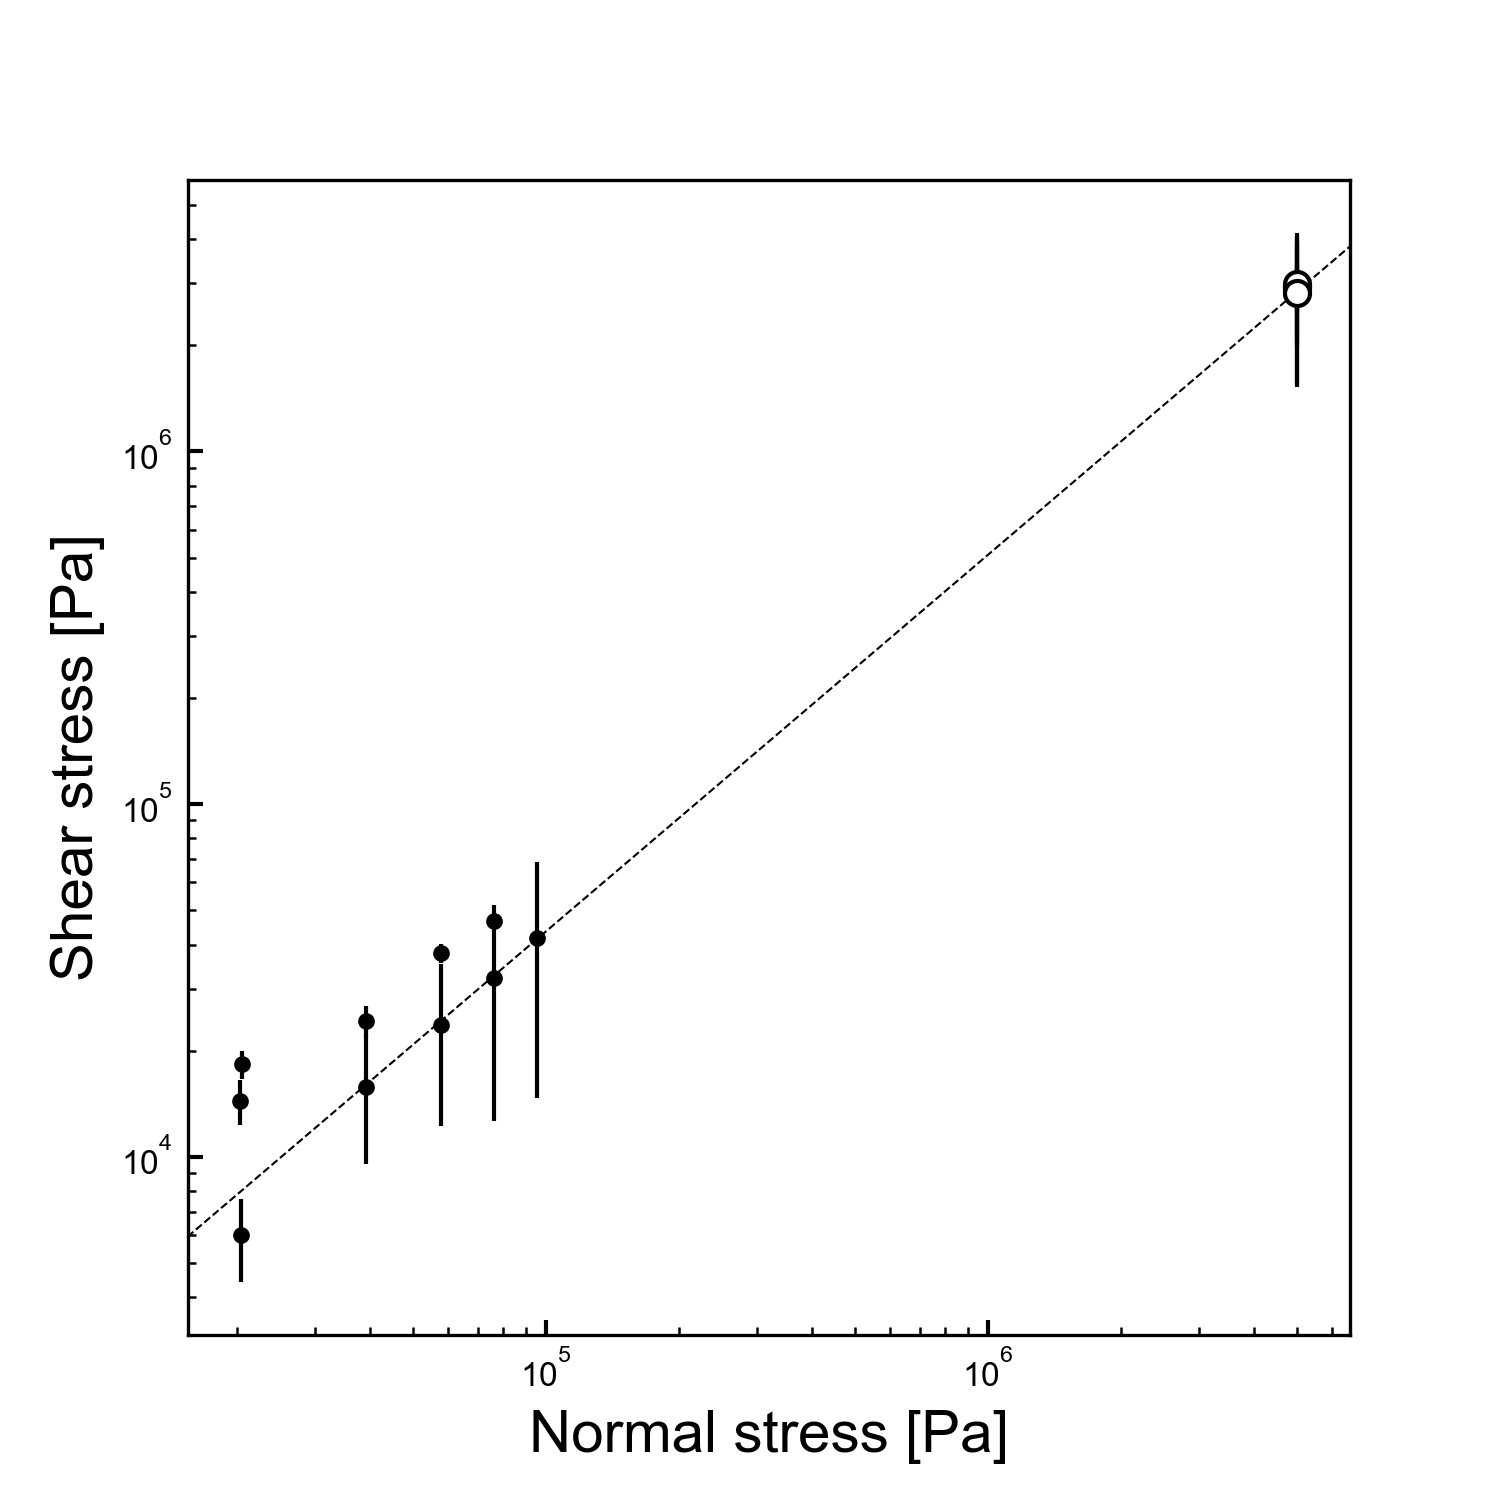

,nf [kPa],sf [kPa],err_sf [kPa]
0,20.378638,6.009280,1.603946
1,20.314050,14.413957,2.117209
2,20.443225,18.327585,1.668104
3,39.109003,15.825429,6.287468
4,39.109003,24.358422,2.437998


In [194]:
def nf_sf():

    csvfile = r"C:\Users\okaza\Box\Laboratory\Azumalab\PreviouStudy\Yasutome\.cache\Schulson&Fortt_fig5.csv"

    df_schulson = pd.read_csv(
        csvfile
    )
    nf_schulson = df_schulson["nf [kPa]"]*1e3
    sf_schulson = df_schulson["sf [kPa]"]*1e3
    
    nf_thisstudy = [5e+6]*5
    sf_thisstudy_up = np.array([
        12.52,
        11.57,
        10.13,
        11.81,
        12.20
    ]) * 1e7 / 30
    sf_thisstudy_down = np.array([
        4.56,
        5.92,
        7.40,
        6.07,
        4.64
    ]) * 1e7 / 30
    sf_center = (sf_thisstudy_up+sf_thisstudy_down)/2
    sf_dif = (sf_thisstudy_up-sf_thisstudy_down)/2

    x = np.hstack([nf_schulson,nf_thisstudy])
    y = np.hstack([sf_schulson,sf_center])
    cov = np.cov(x,y)
    a = cov[0,1]/cov[0,0]
    b = np.mean(y) - a*np.mean(x)
    print(a)

    # # figure作成
    fig, ax = plt.subplots()
    size_inches = (5,5)
    fig.set_size_inches(size_inches)
    fig.set_dpi(300)

    ax.errorbar(
        x = df_schulson["nf [kPa]"]*1e3,
        y = df_schulson["sf [kPa]"]*1e3,
        yerr = df_schulson["err_sf [kPa]"]*1e3,
        lw = 0,
        fmt = "o",
        c = "0",
        ms = 3,
        elinewidth=1,
    )
    
    ax.errorbar(
        x = nf_thisstudy,
        y = sf_center,
        yerr = sf_dif,
        lw = 0,
        fmt = "o",
        c = "0",
        ms = 6,
        elinewidth=1,
        mfc = "1"
    )

    ax.set_xscale("log")
    ax.set_yscale("log")
    xlim = np.array(ax.get_xlim())
    ylim = np.array(ax.get_ylim())
    logxlim = np.log(xlim)
    logylim = np.log(ylim)
    dif = max(logxlim[1]-logxlim[0],logylim[1]-logylim[0])
    logxlim[1] = dif + logxlim[0]
    logylim[1] = dif + logylim[0]
    ylim = np.exp(logylim)
    ax.set_xlim(xlim) # type: ignore
    ax.set_ylim(ylim) # type: ignore

    ax.plot(
        xlim,
        a * xlim + b,
        ls = "dashed",
        lw = 0.5,
        c = "0"
    )
    ax.set_xlabel("Normal stress [Pa]", fontsize = 14)
    ax.set_ylabel("Shear stress [Pa]", fontsize = 14)


    # 出力等
    fig.canvas.draw()
    img = im.frombuffer(
        mode = "RGBA",
        size = fig.canvas.get_width_height(),
        data = fig.canvas.buffer_rgba(), # type: ignore
        decoder_name = "raw"
    )
    key = sys._getframe().f_code.co_name
    imgfilename = os.path.join(cachedir, key + ".png")
    img.save(imgfilename)
    logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
    pdffilename = os.path.join(cachedir, key + ".pdf")
    plt.savefig(pdffilename)
    logger.debug("[Save pdf]: " + os.path.abspath(pdffilename))
    plt.close()
    display(Image(filename = imgfilename, width = size_inches[0]*100))
    

    display(df_schulson.head())


    return
nf_sf()
del nf_sf

,Unnamed: 0,Velocity [m/s],Temperature [K],Normal Force [MPa],Friction Coefficient,Refence
570,2,0.000005,256.0,0.1,0.415,McCarthy+
573,5,0.000005,260.0,0.1,0.389,McCarthy+
577,9,0.000005,253.0,0.1,0.518,McCarthy+
580,12,0.000005,268.0,0.1,0.275,McCarthy+
583,15,0.000005,273.0,0.1,0.075,McCarthy+
587,19,0.000003,255.0,0.1,0.452,McCarthy+
591,23,0.000003,270.0,0.1,0.220,McCarthy+


DEBUG      2025-08-29 20:05:07,857 [897482667.py:90] [Save fig]: c:\Users\okaza\Documents\Friction\.cache\temp_fc.png
DEBUG      2025-08-29 20:05:07,959 [897482667.py:93] [Save pdf]: c:\Users\okaza\Documents\Friction\.cache\temp_fc.pdf


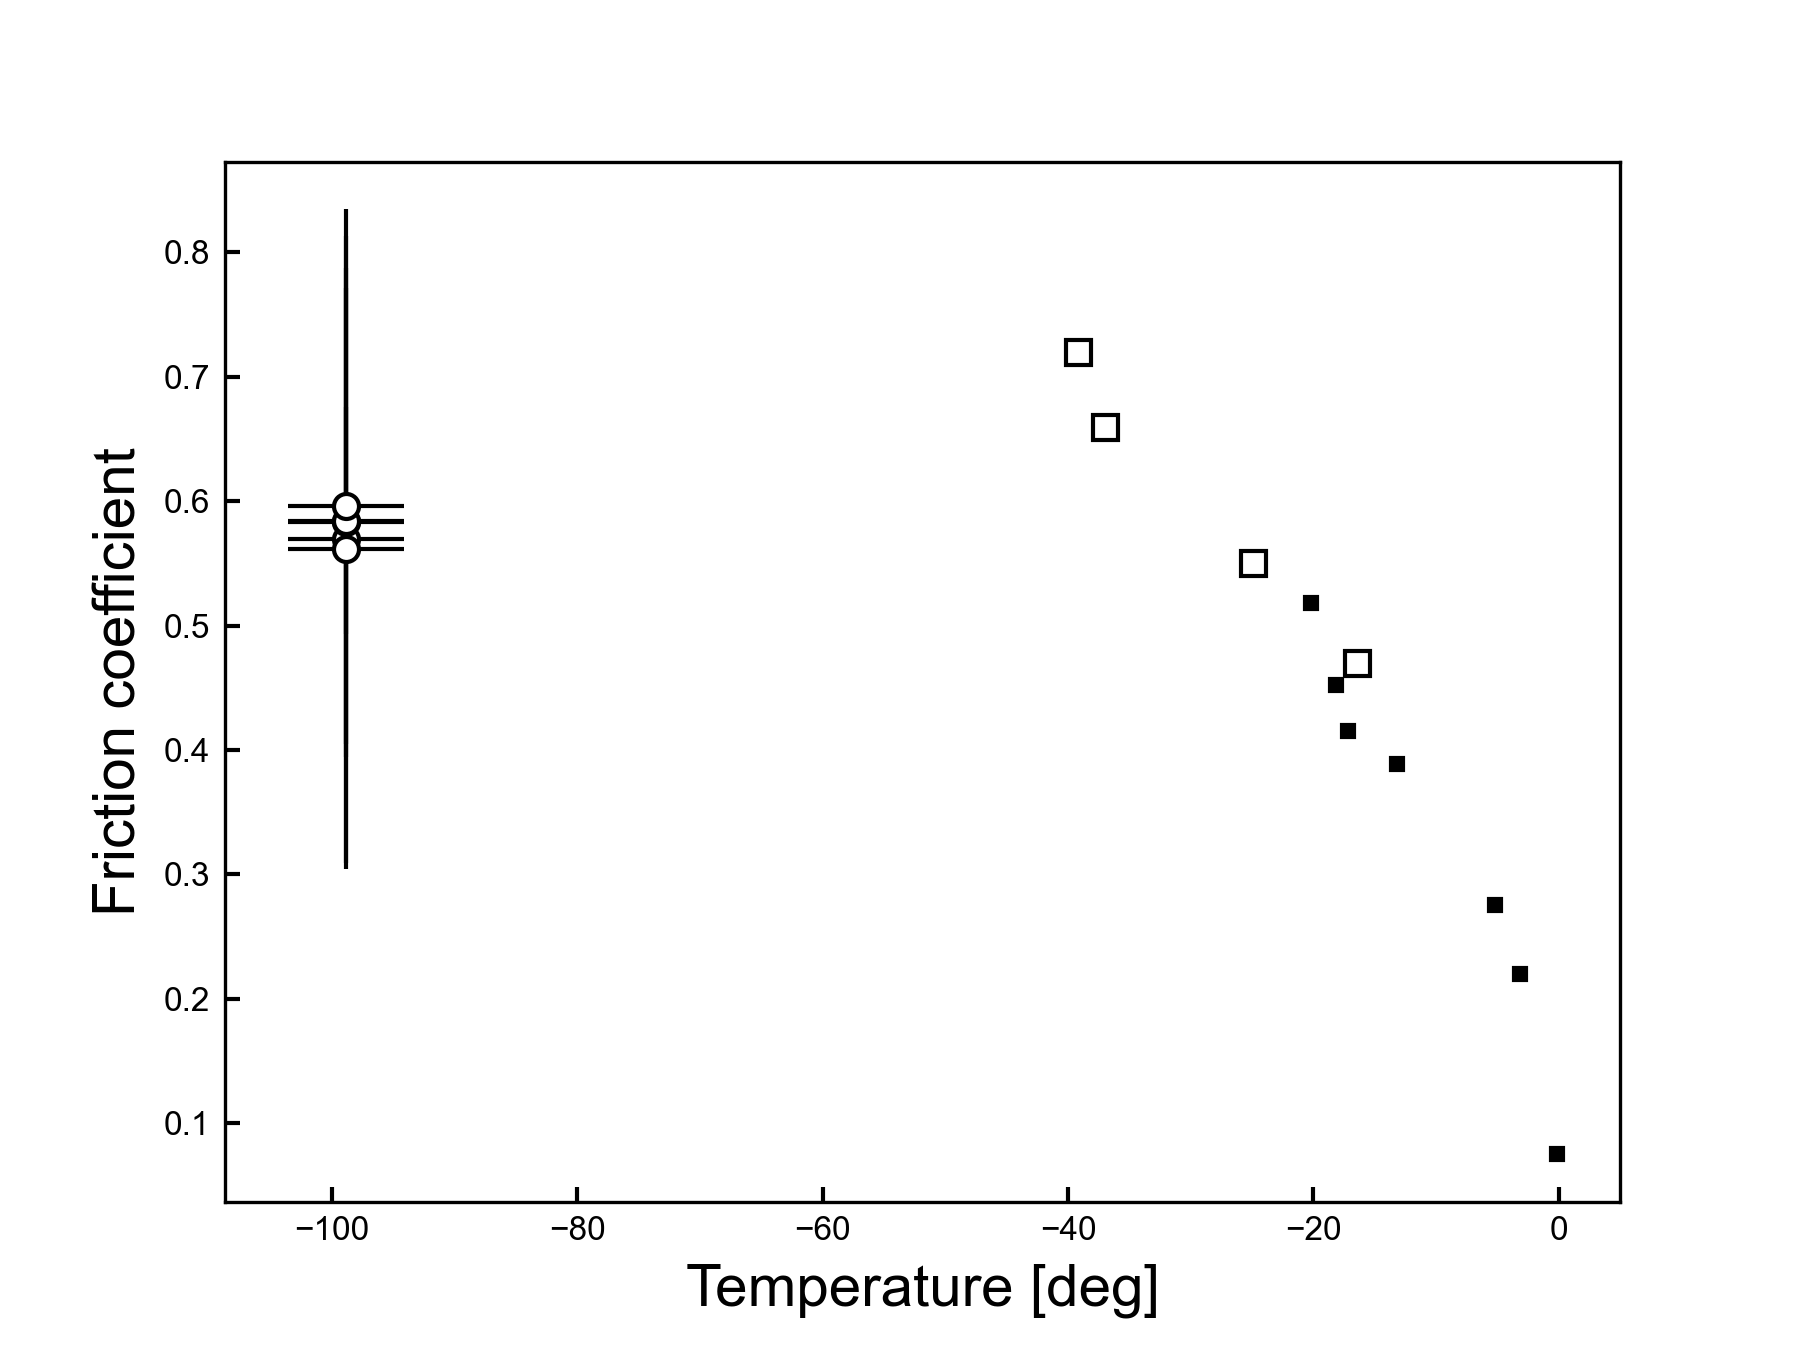

,Unnamed: 0,Velocity [m/s],Temperature [K],Normal Force [MPa],Friction Coefficient,Refence
597,0,0.00003,233.96,2.51,0.72,Okazaki+
598,1,0.00003,236.16,2.50,0.66,Okazaki+
599,2,0.00003,248.26,2.49,0.55,Okazaki+
600,3,0.00003,256.76,2.51,0.47,Okazaki+


In [257]:
def temp_fc():

    csv = r"C:\Users\okaza\Box\Laboratory\Azumalab\PreviouStudy\Yasutome\Data\Data.csv"

    df = pd.read_csv(
        csv
    )
    df_mc = df[df["Refence"] == "McCarthy+"]
    df_mc = df_mc[df_mc["Velocity [m/s]"] > 1e-6]
    df_mc = df_mc[df_mc["Velocity [m/s]"] < 1e-5]
    display(df_mc)

    df_ok = df[df["Refence"] == "Okazaki+"]

    
    nf_thisstudy = [5e+6]*5
    sf_thisstudy_up = np.array([
        12.52,
        11.57,
        10.13,
        11.81,
        12.20
    ]) * 1e7 / 30
    sf_thisstudy_down = np.array([
        4.56,
        5.92,
        7.40,
        6.07,
        4.64
    ]) * 1e7 / 30
    sf_center = (sf_thisstudy_up+sf_thisstudy_down)/2
    sf_dif = (sf_thisstudy_up-sf_thisstudy_down)/2


    # figure作成
    fig, ax = plt.subplots()
    size_inches = (6,4.5)
    fig.set_size_inches(size_inches)
    fig.set_dpi(300)

    ax.plot(
        df_mc["Temperature [K]"] - 273.16,
        df_mc["Friction Coefficient"],
        lw = 0,
        marker = "s",
        ms = 3,
        c = "0",
        label = "McCarthy+ (2017)",
    )
    ax.errorbar(
        df_ok["Temperature [K]"] - 273.16,
        df_ok["Friction Coefficient"],
        xerr = [0.7, 1.1, 0.3, 0.2],
        lw = 0,
        fmt = "s",
        ms = 6,
        mfc = "1",
        c = "0",
        label = "Okazaki+ (2024)",
    )
    ax.errorbar(
        x = [-98.83] * 5,
        y = sf_center / nf_thisstudy,
        xerr = [4.73],
        yerr = sf_dif / nf_thisstudy,
        lw = 0,
        fmt = "o",
        c = "0",
        ms = 6,
        elinewidth = 1,
        mfc = "1",
        label = "This study",
    )
    # ax.legend(fontsize = 10)
    ax.set_xlabel("Temperature [deg]", fontsize = 14)
    ax.set_ylabel("Friction coefficient", fontsize = 14)


    # 出力等
    fig.canvas.draw()
    img = im.frombuffer(
        mode = "RGBA",
        size = fig.canvas.get_width_height(),
        data = fig.canvas.buffer_rgba(), # type: ignore
        decoder_name = "raw"
    )
    key = sys._getframe().f_code.co_name
    imgfilename = os.path.join(cachedir, key + ".png")
    img.save(imgfilename)
    logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
    pdffilename = os.path.join(cachedir, key + ".pdf")
    plt.savefig(pdffilename)
    logger.debug("[Save pdf]: " + os.path.abspath(pdffilename))
    plt.close()
    display(Image(filename = imgfilename, width = size_inches[0]*100))
    
    display(df_ok)

    


    return
temp_fc()
del temp_fc